# **Clustering of Songs into Dynamic Playlists using Spotify User Data**

This notebook is one of our assignments in Sabanci University, Data Analytics master program, 2022. Although the playlist used here belongs to me, this notebook was created by the contributions of all the team members below. However, first light on it was shed by my dear friend Alper Aydin a few years ago. I'd like to thank them all. 

**Project Team:**

* Atacan Karindas - atacan.karindas@sabanciuniv.edu
* Emre Sarac - emresarac@sabanciuniv.edu
* Volkan Yurtseven - volkan.yurtseven@sabanciuniv.edu

## Business Need

Spotify introduced the *Daily Mixes* in 2016 to recommend known and new songs to its users based on their listening habits.

As Spotify playlists are one of the most valuable features, these dynamic albums were an instant hit.

However, Spotify still has one issue to deal with - organizing liked *songs* that are not in a playlist.

If you've used Spotify to save *like* a song (which adds a tag to the song but does not add it to a playlist, the song usually disappears in a huge list of other *liked* songs that may be completely irrelevant to it.

So what if we could make the user generated playlists *dynamic* as well? Find which playlist the *liked* song would fit best and offer the user the opportunity to do it directly to the right playlist?

**Hypothesis**

We believe, by looking at the different properties of songs, we can create *clusters* that can group songs that are similar.

Then, we can create a *classification* model that will help us determine which playlist it would fit best and assign the song to the relevant playlist.

A successful implementation of this approach would automate some tedious tasks for Spotify's users and create a distinct advantage over its competitors.

## ML in concise

**NOTE:Those who are acquainted with ML may skip this part**

To keep the notebook short, I'll refer to you a <a href="https://mvolkanyurtseven.medium.com/makine-%C3%B6%C4%9Frenimi-felsefesi-1-fb1b10428a7c">post</a> written by me, which is in Turkish. If you are not Turkish, feel free to check any other links below:

- https://en.wikipedia.org/wiki/Machine_learning
- https://www.ibm.com/cloud/learn/machine-learning

## Spotify API

https://spotipy.readthedocs.io/en/latest/

https://developer.spotify.com/web-api/

https://medium.com/@samlupton/spotipy-get-features-from-your-favourite-songs-in-python-6d71f0172df0

In [ ]:
# !pip install spotipy
# !pip install forbiddenfruit-->for the extension methods to be able to work
# !pip install pandas_flavor-->for the extension methods to be able to work

## Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spotify_external import *

import spotipy
#import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
pd.set_option('display.max_rows',None)  
pd.set_option('display.min_rows',None) 

**NOTE:** If you want to run the notebook, please now jump to **"Reading data"** section.

# Using API to get the data

## Set Credentials


In [ ]:
from getpass import getpass
client_id =  getpass("client id: ")
client_secret = getpass("client secret: ")
usr='11133966425'

client id: ········
client secret: ········


In [ ]:
#Method2 for playlists. note the scope parameter, #you'll be addressed your redirection uri, copy and paste the link
#user-library-read, playlist-read-private, playlist-modify-private. find others at #https://developer.spotify.com/documentation/general/guides/scopes/
def getToken(scope):    
    token = util.prompt_for_user_token(username=usr,
                               scope=scope, 
                               client_id=client_id,
                               client_secret=client_secret,
                               redirect_uri='http://www.volkanyurtseven.com')
    return token

spm = spotipy.Spotify(auth=getToken('playlist-modify-private')) #handling playlists
sp = spotipy.Spotify(auth=getToken('user-library-read')) #reading from library

Enter the URL you were redirected to: http://www.volkanyurtseven.com/?code=AQDQgRSRpVImIxEoDFU08V7qtyACw3sUkdda1AYBo_wcEx8P56FA916UP7ka8EmJKp7bF462FPJa4TDOGLsX2XPp0nrdm0JekY00EcQQ2a1xG3KsbNx1HFUNeR5SI_jDnAtSQWB4QGo_wFl-HnHU9wHwsrA8nDWUgaCf8xT2Y2Ej4f0rv73sh2hmH9SniupGIzURDEoNZr2v2vQ
Enter the URL you were redirected to: http://www.volkanyurtseven.com/?code=AQCaSNRDEbUCcDPnfBoAsvhqwFlGvX-f9wgtcqyj_ZN0qWoOEK7VCwyYsnd3I6oCMvhhXFX4XV4Y6nufxrhXOVprSYnn2oUOlXhgq9dTYxhqKd3glBE0HI2I6naDRBd9kJVIpu9fPlCbSpo3IxkRlzZ96v1SjzmdTfCsLTovTQUEqgMZZ5AO0tmK_CbccOuNPwMxs34


## Getting to know the API

In [ ]:
sp.current_user()

{'display_name': 'Volkan Yurtseven',
 'external_urls': {'spotify': 'https://open.spotify.com/user/11133966425'},
 'followers': {'href': None, 'total': 11},
 'href': 'https://api.spotify.com/v1/users/11133966425',
 'id': '11133966425',
 'images': [{'height': None,
   'url': 'https://scontent-ams4-1.xx.fbcdn.net/v/t31.18172-1/14409451_10154502155559424_5907727609507222216_o.jpg?stp=dst-jpg_p320x320&_nc_cat=105&ccb=1-7&_nc_sid=0c64ff&_nc_ohc=s_kKjANLgQsAX_89Ms_&_nc_ht=scontent-ams4-1.xx&edm=AP4hL3IEAAAA&oh=00_AT9KWYMe1TTEQFD7tK4lNnP_QrZN2xHKbDXzb7ZESZCrFw&oe=631B1152',
   'width': None}],
 'type': 'user',
 'uri': 'spotify:user:11133966425'}

Spotify's User REST API response is a JSON object that returns information about both the connection and the user.

Data is wrapped in an object list, with each JSON object containing data about user's activities.

In [ ]:
#if we are interested in playlists
pls=sp.current_user_playlists() #returns a dictionary
pls.keys()

dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

In [ ]:
[x["name"] for x in pls["items"]]

['Özgün coşku',
 'Özgün soft',
 'Chillout - Old Classic',
 'Chillout - Instrumental',
 'Chillout - MorningCoffee',
 'Chillout - New Age',
 'Slow pure',
 'Slowish PopRock',
 'Vivid - Classic',
 'Vivid- Instrumental',
 'Vivid- RapHiphop',
 'Vivid - Soft',
 'TürküDeyiş']

In [ ]:
#looking the contents of all these keys, we see that what we need is "items" key
pls["items"][0]

{'collaborative': False,
 'description': '',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/0Ya2oRSIpdA8PRraUqzE5a'},
 'href': 'https://api.spotify.com/v1/playlists/0Ya2oRSIpdA8PRraUqzE5a',
 'id': '0Ya2oRSIpdA8PRraUqzE5a',
 'images': [{'height': 640,
   'url': 'https://mosaic.scdn.co/640/ab67616d0000b27347eeef512120db38f71c18b7ab67616d0000b2735791834cd47fc807d114b778ab67616d0000b2737be3f9174b5aae6c224abdf4ab67616d0000b273d39016a5a111d5897f72f666',
   'width': 640},
  {'height': 300,
   'url': 'https://mosaic.scdn.co/300/ab67616d0000b27347eeef512120db38f71c18b7ab67616d0000b2735791834cd47fc807d114b778ab67616d0000b2737be3f9174b5aae6c224abdf4ab67616d0000b273d39016a5a111d5897f72f666',
   'width': 300},
  {'height': 60,
   'url': 'https://mosaic.scdn.co/60/ab67616d0000b27347eeef512120db38f71c18b7ab67616d0000b2735791834cd47fc807d114b778ab67616d0000b2737be3f9174b5aae6c224abdf4ab67616d0000b273d39016a5a111d5897f72f666',
   'width': 60}],
 'name': 'Özgün coşku',
 'owner': {'disp

In [ ]:
#if we are interested in liked songs
st=sp.current_user_saved_tracks()
st["items"][0]

{'added_at': '2022-07-06T05:23:20Z',
 'track': {'album': {'album_type': 'single',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4FcZfItjVIsfO9TynErl7X'},
     'href': 'https://api.spotify.com/v1/artists/4FcZfItjVIsfO9TynErl7X',
     'id': '4FcZfItjVIsfO9TynErl7X',
     'name': 'Jubël',
     'type': 'artist',
     'uri': 'spotify:artist:4FcZfItjVIsfO9TynErl7X'},
    {'external_urls': {'spotify': 'https://open.spotify.com/artist/71Dhj822M1LGpuryPIV2KO'},
     'href': 'https://api.spotify.com/v1/artists/71Dhj822M1LGpuryPIV2KO',
     'id': '71Dhj822M1LGpuryPIV2KO',
     'name': 'NEIMY',
     'type': 'artist',
     'uri': 'spotify:artist:71Dhj822M1LGpuryPIV2KO'}],
   'available_markets': ['AD',
    'AE',
    'AG',
    'AL',
    'AM',
    'AO',
    'AR',
    'AT',
    'AZ',
    'BA',
    'BB',
    'BD',
    'BE',
    'BF',
    'BG',
    'BH',
    'BI',
    'BJ',
    'BN',
    'BO',
    'BR',
    'BS',
    'BT',
    'BW',
    'BY',
    'BZ',
    'CA',
    'CD',

In [ ]:
#Collecting the list of likes songs
#Trace errors can be disregarded
likedsongs=[]
for i in range(15):  #14 is enough, because i know i have just about 650 songs  
    temp=sp.current_user_saved_tracks(limit=50,offset=i*50) #we have to loop through as it returns max 50 songs at each run
    likedsongs.extend((x["track"]["id"],x["track"]["name"],x["track"]["artists"][0]["name"]) for x in temp["items"])
likedsongs[0]
len(likedsongs)

('4GSDkZt7GcmzBWmsMcpaVO', 'Dancing In The Moonlight (feat. NEIMY)', 'Jubël')

658

## Getting Tracks of a Playlist

Moving forward, we'll create the following function to creates a list of liked songs.

In [ ]:
def GetSongsInPlaylist(username):
    pls = sp.user_playlists(username)
    pl_items=pls["items"]
    playlists=[]
    songlist=[]
    for item in pl_items:
        if item["owner"]["id"]==usr:
            playlists.append(item['id'])
    
    for pli in playlists:        
        pl=sp.user_playlist(username,pli)
        songs=pl["tracks"]['items']
        for i in range(len(songs)):
            song=songs[i]['track']
            if song["id"] not in [x for x,y in songlist]: #control for duplicates. we're simply getting the first playlist
                songlist.append((song["id"],pl["name"]))
    
    return songlist

In [ ]:
#disregard the error
playlistsongs=GetSongsInPlaylist(usr)
playlistsongs[0]
len(playlistsongs)

('1tLORE7MX4xLeh5KG3ACw0', 'Özgün coşku')

334

Let's find the songs that are in the library but not added to playlists and vice versa:

In [ ]:
plss=[s for s,_ in playlistsongs]
ls=[s for s,_,_2 in likedsongs]
diff1=set(ls).difference(set(plss))
len(diff1)

352

In [ ]:
diff2=set(plss).difference(set(ls))
len(diff2)

28

We'll cross-append the missing songs later.

## Getting the attributes of songs

In [ ]:
sp.audio_features(["2c0zRRIEPc6euLBiWzEW6O"])

[{'danceability': 0.563,
  'energy': 0.0026,
  'key': 2,
  'loudness': -32.693,
  'mode': 0,
  'speechiness': 0.372,
  'acousticness': 0.993,
  'instrumentalness': 0.973,
  'liveness': 0.0695,
  'valence': 0.0504,
  'tempo': 96.809,
  'type': 'audio_features',
  'id': '2c0zRRIEPc6euLBiWzEW6O',
  'uri': 'spotify:track:2c0zRRIEPc6euLBiWzEW6O',
  'track_href': 'https://api.spotify.com/v1/tracks/2c0zRRIEPc6euLBiWzEW6O',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2c0zRRIEPc6euLBiWzEW6O',
  'duration_ms': 182693,
  'time_signature': 4}]

In [ ]:
#combining songs with their attributes
df_songs=pd.DataFrame(likedsongs,columns=["id","SongName","Artist"])
df_pls=pd.DataFrame(playlistsongs,columns=["id","playlist"]).drop_duplicates()
list_=[sp.audio_features(s)[0] for s in ls]
df_attr=pd.DataFrame(list_) 
finalDf=pd.concat([df_attr,df_songs.drop("id",axis=1)],axis=1)
finalDf=finalDf.merge(df_pls,on="id",how="left")
finalDf.drop(["analysis_url","track_href","uri","type","duration_ms"],inplace=True,axis=1) #remove unnecessary features
finalDf.sample(5) #let's see any 5 tracks

danceability  energy  key  loudness  mode  speechiness  acousticness  \
193         0.658  0.2460   11   -13.133     0       0.0297         0.673   
198         0.649  0.8440    2    -5.349     0       0.0688         0.482   
159         0.346  0.0098    1   -32.212     1       0.0438         0.990   
570         0.734  0.4430    7   -10.873     1       0.0270         0.657   
33          0.433  0.5640    9    -8.917     0       0.0405         0.713   

     instrumentalness  liveness  valence    tempo                      id  \
193          0.000001    0.1130   0.2670  110.057  5tqjXqatzjb25QqXgKirzy   
198          0.000307    0.1600   0.9280  165.951  0xNW1WrxJP3USOL2r0gqHE   
159          0.909000    0.0746   0.0394  119.992  0IlmPZGIQb1j1eOV0q3RZ9   
570          0.000001    0.2510   0.5520  118.021  5h3B2E7tSVOSkvfwp5JxhX   
33           0.275000    0.1170   0.8550  192.073  01Q55Xv60Gr56abx5ad5vK   

     time_signature                                 SongName           Artist  \
193               4                               It's a Sin   James Farrelli   
198               4                                      Mod   Mustafa Sandal   
159               3  Nocturnes, Op. 9: No. 1 in B-Flat Minor  Frédéric Chopin   
570               3                                  Beni Al          Pinhani   
33                3                        La valse d'Amélie     Yann Tiersen   

            playlist  
193              NaN  
198              NaN  
159              NaN  
570  Slowish PopRock  
33               NaN

In [ ]:
finalDf["Artist-Song"]=finalDf.Artist+"-"+finalDf.SongName
finalDf.set_index("Artist-Song",inplace=True)
finalDf.drop(["Artist","SongName"],axis=1,inplace=True)

In [ ]:
finalDf.head()

danceability  energy  key  \
Artist-Song                                                               
Jubël-Dancing In The Moonlight (feat. NEIMY)         0.659   0.615   11   
Camila Cabello-Bam Bam (feat. Ed Sheeran)            0.756   0.697    8   
Sia-1+1                                              0.862   0.641    0   
Jabbar-Aldatıldık                                    0.767   0.658    9   
Sia-Unstoppable                                      0.468   0.779    9   

                                              loudness  mode  speechiness  \
Artist-Song                                                                 
Jubël-Dancing In The Moonlight (feat. NEIMY)    -5.865     0       0.0644   
Camila Cabello-Bam Bam (feat. Ed Sheeran)       -6.377     1       0.0401   
Sia-1+1                                         -4.109     1       0.0442   
Jabbar-Aldatıldık                               -8.873     0       0.0557   
Sia-Unstoppable                                 -4.839     1       0.0779   

                                              acousticness  instrumentalness  \
Artist-Song                                                                    
Jubël-Dancing In The Moonlight (feat. NEIMY)         0.270          0.000000   
Camila Cabello-Bam Bam (feat. Ed Sheeran)            0.182          0.000000   
Sia-1+1                                              0.120          0.000010   
Jabbar-Aldatıldık                                    0.511          0.002700   
Sia-Unstoppable                                      0.112          0.000373   

                                              liveness  valence    tempo  \
Artist-Song                                                                
Jubël-Dancing In The Moonlight (feat. NEIMY)     0.187    0.193  119.843   
Camila Cabello-Bam Bam (feat. Ed Sheeran)        0.333    0.956   94.996   
Sia-1+1                                          0.336    0.674  109.998   
Jabbar-Aldatıldık                                0.108    0.713   95.001   
Sia-Unstoppable                                  0.101    0.260  173.799   

                                                                  id  \
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)  4GSDkZt7GcmzBWmsMcpaVO   
Camila Cabello-Bam Bam (feat. Ed Sheeran)     3lDSWvR0FXWGXo7mhDUs3v   
Sia-1+1                                       71Taskl2O73XfpQtJciJCD   
Jabbar-Aldatıldık                             5E1gxNXvUGvpvUECz54xXm   
Sia-Unstoppable                               1yvMUkIOTeUNtNWlWRgANS   

                                              time_signature playlist  
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)               4      NaN  
Camila Cabello-Bam Bam (feat. Ed Sheeran)                  4      NaN  
Sia-1+1                                                    4      NaN  
Jabbar-Aldatıldık                                          4      NaN  
Sia-Unstoppable                                            4      NaN

Normally, we could have used the finalDf from here on, but in case you want to run the notebook, we decided to export the data, so you can read it and continue from following section.

In [ ]:
finalDf.to_csv("volkans_liked_songs.csv")

# Reading data

In [ ]:
songs=pd.read_csv("volkans_liked_songs.csv")
songs.set_index("Artist-Song",inplace=True)
songs.head()

danceability  energy  key  \
Artist-Song                                                               
Jubël-Dancing In The Moonlight (feat. NEIMY)         0.659   0.615   11   
Camila Cabello-Bam Bam (feat. Ed Sheeran)            0.756   0.697    8   
Sia-1+1                                              0.862   0.641    0   
Jabbar-Aldatıldık                                    0.767   0.658    9   
Sia-Unstoppable                                      0.468   0.779    9   

                                              loudness  mode  speechiness  \
Artist-Song                                                                 
Jubël-Dancing In The Moonlight (feat. NEIMY)    -5.865     0       0.0644   
Camila Cabello-Bam Bam (feat. Ed Sheeran)       -6.377     1       0.0401   
Sia-1+1                                         -4.109     1       0.0442   
Jabbar-Aldatıldık                               -8.873     0       0.0557   
Sia-Unstoppable                                 -4.839     1       0.0779   

                                              acousticness  instrumentalness  \
Artist-Song                                                                    
Jubël-Dancing In The Moonlight (feat. NEIMY)         0.270          0.000000   
Camila Cabello-Bam Bam (feat. Ed Sheeran)            0.182          0.000000   
Sia-1+1                                              0.120          0.000010   
Jabbar-Aldatıldık                                    0.511          0.002700   
Sia-Unstoppable                                      0.112          0.000373   

                                              liveness  valence    tempo  \
Artist-Song                                                                
Jubël-Dancing In The Moonlight (feat. NEIMY)     0.187    0.193  119.843   
Camila Cabello-Bam Bam (feat. Ed Sheeran)        0.333    0.956   94.996   
Sia-1+1                                          0.336    0.674  109.998   
Jabbar-Aldatıldık                                0.108    0.713   95.001   
Sia-Unstoppable                                  0.101    0.260  173.799   

                                                                  id  \
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)  4GSDkZt7GcmzBWmsMcpaVO   
Camila Cabello-Bam Bam (feat. Ed Sheeran)     3lDSWvR0FXWGXo7mhDUs3v   
Sia-1+1                                       71Taskl2O73XfpQtJciJCD   
Jabbar-Aldatıldık                             5E1gxNXvUGvpvUECz54xXm   
Sia-Unstoppable                               1yvMUkIOTeUNtNWlWRgANS   

                                              time_signature playlist  
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)               4      NaN  
Camila Cabello-Bam Bam (feat. Ed Sheeran)                  4      NaN  
Sia-1+1                                                    4      NaN  
Jabbar-Aldatıldık                                          4      NaN  
Sia-Unstoppable                                            4      NaN

# EDA(Exploratory Data Analysis)

We'll begin by discovering the properties of our Spotify data and gain insight into how we can build our ML models.

Discovering patterns, correlations and better understanding how song properties relate to listener behaviour will be the critical goal of this chapter.

## General idea about data

We will be transforming the original data troughout the EDA process.

We'll also save a copy of the original data for later use.

In [ ]:
df=songs.copy()

In [ ]:
len(df)

658

In [ ]:
#Removing duplicates
dupidx=pd.RangeIndex(len(df))[df.index.isin(df[df.index.duplicated()].index)]
df.iloc[dupidx]

danceability  energy  key  \
Artist-Song                                                                     
Lofi Fruits Music-Faded                                    0.558   0.391    1   
Lofi Fruits Music-Yesterday                                0.696   0.301    5   
Ava Max-So Am I                                            0.681   0.657    6   
Deniz Tekin-Beni Vur - Akustik                             0.474   0.238    1   
Lofi Fruits Music-Yesterday                                0.690   0.288    5   
Lofi Fruits Music-Faded                                    0.558   0.387    1   
Ava Max-So Am I                                            0.682   0.656    6   
Deniz Tekin-Beni Vur - Akustik                             0.474   0.238    1   
Petula Clark-Downtown                                      0.498   0.552    4   
Roxette-It Must Have Been Love - From the Film ...         0.520   0.652    5   
Multitap-Ben Anlarım                                       0.654   0.655    4   
Amy Macdonald-This Is The Life                             0.628   0.882    1   
Indila-Boite En Argent                                     0.445   0.302    7   
Indila-Love Story                                          0.375   0.255   10   
Indila-S.O.S                                               0.531   0.587    6   
Indila-Dernière danse                                      0.669   0.449    0   
Indila-Tourner Dans Le Vide                                0.594   0.698    6   
Infernal-Self Control                                      0.650   0.975    6   
Infernal-Self Control                                      0.598   0.994    6   
Israel Kamakawiwo'ole-Over the Rainbow                     0.671   0.153    0   
Lady Gaga-Alejandro                                        0.626   0.799   11   
Lady Gaga-Bad Romance                                      0.696   0.921    0   
Makis Ablianitis-Love Secret                               0.600   0.635    2   
Makis Ablianitis-Love Secret                               0.515   0.417    2   
The Byrds-Mr. Tambourine Man                               0.456   0.470    2   
Israel Kamakawiwo'ole-Over the Rainbow                     0.671   0.153    0   
Petula Clark-Downtown                                      0.480   0.689    4   
Indila-Mini World                                          0.563   0.541   11   
Grup Yorum-Uğurlama                                        0.625   0.357    7   
Ahmet Kaya-Acılara Tutunmak                                0.533   0.625    0   
Ahmet Kaya-Acılara Tutunmak                                0.477   0.478    1   
Lady Gaga-Bad Romance                                      0.693   0.924    0   
Lady Gaga-Alejandro                                        0.626   0.799   11   
Yann Tiersen-Comptine d'un autre été, l'après-midi         0.484   0.192    2   
Roxette-It Must Have Been Love - From the Film ...         0.520   0.652    5   
Simon & Garfunkel-The Sound of Silence                     0.534   0.235    6   
Simon & Garfunkel-The Sound of Silence                     0.435   0.456    6   
Multitap-Ben Anlarım                                       0.653   0.668    4   
Grup Yorum-Uğurlama                                        0.629   0.470    7   
Yann Tiersen-Comptine d'un autre été, l'après-midi         0.484   0.192    2   
Lady Gaga-Bad Romance                                      0.696   0.921    0   
Lady Gaga-Alejandro                                        0.623   0.793   11   
Amy Macdonald-This Is The Life                             0.628   0.882    1   
Lana Del Rey-West Coast                                    0.543   0.580    6   
The Byrds-Mr. Tambourine Man                               0.481   0.628    2   
Lana Del Rey-West Coast                                    0.424   0.624    6   
Indila-S.O.S                                               0.531   0.587    6   
Indila-Dernière danse                                      0.669   0.449    0   
In

In [ ]:
dupdf=pd.DataFrame({"idx":dupidx,"track": df.iloc[dupidx].index})
tobedropped=dupdf[dupdf.duplicated(subset="track")].idx.values
tobedropped

array([ 50,  51, 116, 121, 229, 256, 277, 285, 403, 440, 443, 501, 566,
       597, 601, 611, 615, 616, 623, 628, 633, 634, 635, 636, 637, 640,
       641, 642], dtype=int64)

In [ ]:
kept=[x for x in range(650) if x not in tobedropped]
df=df.iloc[kept]

In [ ]:
len(df)

622

As *id* parameter solely relates to each song, we'll remove it from our dataframe to reduce complexity and noise.

We'll keep the *playlist* column as we may use it with the purpose of comparison with the cluster labels.

In [ ]:
del df["id"]

In [ ]:
#Fundamental statistics
df.describe() 

danceability      energy         key    loudness        mode  \
count    622.000000  622.000000  622.000000  622.000000  622.000000   
mean       0.517969    0.482539    5.303859  -10.561047    0.416399   
std        0.169422    0.233663    3.510181    5.166844    0.493358   
min        0.063800    0.002600    0.000000  -36.045000    0.000000   
25%        0.418250    0.299250    2.000000  -12.996000    0.000000   
50%        0.540500    0.488500    5.000000   -9.519000    0.000000   
75%        0.643750    0.657000    9.000000   -6.929000    1.000000   
max        0.904000    0.994000   11.000000   -1.988000    1.000000   

       speechiness  acousticness  instrumentalness    liveness     valence  \
count   622.000000    622.000000        622.000000  622.000000  622.000000   
mean      0.046149      0.496174          0.172094    0.174799    0.415225   
std       0.032740      0.331378          0.330524    0.148717    0.240196   
min       0.022400      0.000013          0.000000    0.033100    0.034100   
25%       0.030800      0.182250          0.000000    0.096200    0.226250   
50%       0.037050      0.495000          0.000097    0.118000    0.382000   
75%       0.047375      0.810000          0.050275    0.189000    0.585000   
max       0.372000      0.996000          0.980000    0.959000    0.964000   

            tempo  time_signature  
count  622.000000      622.000000  
mean   118.332881        3.881029  
std     30.578362        0.411580  
min     49.885000        1.000000  
25%     94.056500        4.000000  
50%    118.829500        4.000000  
75%    139.146500        4.000000  
max    192.073000        5.000000

Some notes about domain specific features:

- **mode:** Major is represented by 1 and minor is 0. So actually these are categorical values, not continous.
- **key:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. These are categoricals as well, but ordinal values.
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- **time signature:** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar.

More details about the features as determined by Spotify are available in this page: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

**NOTE:**

*Speechiness* is explained as follows by Spotify:

*Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.*

However, some manual heuristic testing of the data revealed a conflict with the explanation provided and the actual charactistics of the songs.

This indicates a potential quality issue with the Spotify data.

More research showed that other fellow data scientists encountered the same problem. (tazaraz, 2022)*

Therefore, we've decided to remove *Speecihiness* to avoid quality issues.

*“API Endpoint Audio Features Speechiness Returning Incorrect Values.” Community.spotify.com, 1 June 2022, community.spotify.com/t5/Spotify-for-Developers/API-endpoint-Audio-Features-speechiness-returning-incorrect/m-p/5388882. Accessed 13 July 2022.*


In [ ]:
del df["speechiness"]

We'll have a look at the value range (min-max) of the features to check if we'll need to scale the data in order to ensure weight balance between features.

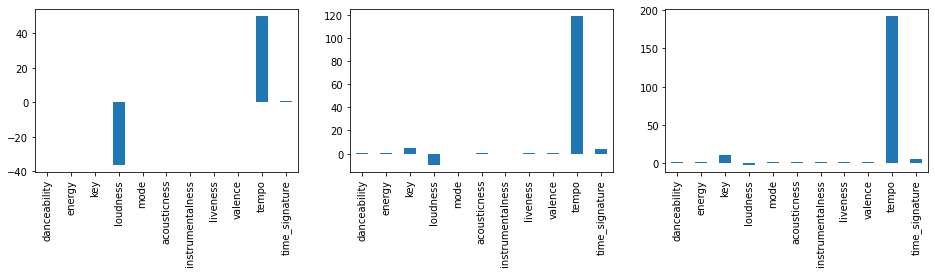

In [ ]:
plotRange(df.describe())    

We can see that the min-max ranges of *loudness* and *tempo* are much larger than the others without additional statistical test. This will cause them to have a large impact in the decision making process of our ML model.

Therefore, we'll need to scale the data to get more relevant outcomes.

In [ ]:
df.super_info_()

Type  Nunique  #of Missing  MostFreqItem  MostFreqCount  \
danceability      float64      387            0         0.533              7   
energy            float64      439            0         0.214              5   
key                 int64       12            0             9             82   
loudness          float64      607            0        -9.736              2   
mode                int64        2            0             0            363   
acousticness      float64      495            0           0.8              6   
instrumentalness  float64      424            0           0.0            165   
liveness          float64      354            0         0.112             12   
valence           float64      439            0         0.256              5   
tempo             float64      618            0       160.079              2   
time_signature      int64        4            0             4            532   
playlist           object       14          324  Vivid - Soft             92   

                 Jubël-Dancing In The Moonlight (feat. NEIMY)  
danceability                                            0.659  
energy                                                  0.615  
key                                                        11  
loudness                                               -5.865  
mode                                                        0  
acousticness                                             0.27  
instrumentalness                                          0.0  
liveness                                                0.187  
valence                                                 0.193  
tempo                                                 119.843  
time_signature                                              4  
playlist                                                  NaN

We currently have 12 features, each in number format.

We'll do some frequency based analysis of each future to see how different values relate to our business goal in general and to determine how to treat different numeric features. (e.g. as numeric, ordinal, etc.)

First, we'll check the unique values in features with low cardinality.

In [ ]:
getColumnsInLowCardinality(df,12)

Unique items in column key
[11  8  0  9  4  1  7  5  2  3  6 10]

Unique items in column mode
[0 1]

Unique items in column time_signature
[4 3 1 5]

You may want to consider the numerics with low cardinality as categorical in the analysis


['key', 'mode', 'time_signature']

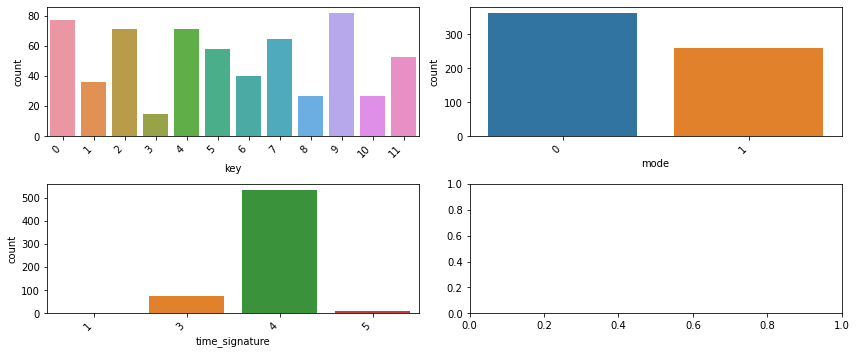

In [ ]:
#Drawing a countplot these 3 features with low cardinality
multicountplot(df,12,colsize=2,fig=(12,5));

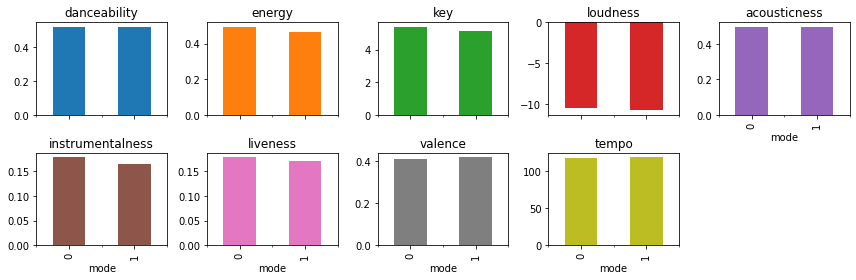

In [ ]:
#Plotting the mode of each feature
n=list(df.select_dtypes("number").drop(["mode","time_signature"],axis=1).columns)
plotNumericsByTarget(df,"mode",nums=n,layout=(2,5),figsize=(12,4))

We did not encounter a visible difference when evaluated by *mode*.

Next, we'll look do some manual evaluation of tracks with *mode* values {0,1}. 

In [ ]:
df[df["mode"]==1]

danceability  energy  key  \
Artist-Song                                                                     
Camila Cabello-Bam Bam (feat. Ed Sheeran)                 0.7560  0.6970    8   
Sia-1+1                                                   0.8620  0.6410    0   
Sia-Unstoppable                                           0.4680  0.7790    9   
Angèle-Balance ton quoi                                   0.7030  0.4420    0   
Angèle-Bruxelles je t’aime                                0.7400  0.5670    0   
Saint-Preux-Concerto Pour Une Voix                        0.3120  0.2820    1   
Gheorghe Zamfir-Time to Say Goodbye                       0.1520  0.4370    7   
Sarah Brightman-Time To Say Goodbye                       0.2520  0.5000    5   
Tarlan Gazanferoğlu-Silk Road                             0.2350  0.3890    7   
Céline Dion-The Power of Love                             0.5460  0.5190    8   
Céline Dion-Pour que tu m'aimes encore                    0.5370  0.6020    2   
Emilíana Torrini-Sounds of silence                        0.5790  0.5150    0   
Lofi Fruits Music-Pastel Reflections                      0.6280  0.1080   11   
Lofi Fruits Music-Yesterday                               0.6960  0.3010    5   
Lofi Fruits Music-Hotel California                        0.6540  0.3410    0   
Sam Brown-Stop                                            0.3260  0.3000    9   
Ava Max-So Am I                                           0.6810  0.6570    6   
Atomic Kitten-Eternal Flame                               0.5810  0.5900    2   
Lofi Fruits Music-Memories                                0.7230  0.3200   11   
Lofi Fruits Music-Shallow                                 0.5410  0.3670    7   
Lofi Fruits Music-Bubbly                                  0.6710  0.2650    9   
Lofi Fruits Music-Over the rainbow                        0.7040  0.1910    0   
Lofi Fruits Music-Chandelier                              0.5600  0.5270    1   
Lofi Fruits Music-Dancing in the Moonlight                0.6050  0.3360    9   
Lofi Fruits Music-Can't Help Falling in Love              0.2730  0.3160    0   
Mark Davies-Take on Me                                    0.5780  0.6200    9   
Ely Bruna-Take On Me                                      0.6380  0.3910    7   
Andre Fenrir-Take on Me (The Last of Us Part 2)           0.6070  0.0991   11   
Yeliz-Yalan                                               0.4250  0.6780    9   
Bumerang-Sensiz Yıllarda                                  0.6590  0.9250    1   
Luigi Boccherini-String Quintet in E Major, Op....        0.4980  0.0789    9   
Charles Gounod-Ave Maria: Arr. From Bach's Prel...        0.1130  0.1470    0   
Antonín Dvořák-4 Romantic Pieces, Op. 75, B. 15...        0.2070  0.0591   10   
2CELLOS-Despacito                                         0.6290  0.4030    2   
2CELLOS-Imagine                                           0.3560  0.0823    0   
2CELLOS-Moon River                                        0.1780  0.2480    7   
2CELLOS-May it Be                                         0.1700  0.2740    7   
Lost Frequencies-Sun is Shining                           0.6190  0.8520    1   
Ava Max-Who's Laughing Now                                0.6480  0.6410    7   
Ava Max-Salt                                              0.6930  0.8350    6   
Mr. Big-Wild World - 2009 Remastered Version              0.5730  0.7220    5   
Aşkın Nur Yengi-Bir Zaman Hatası                          0.7140  0.6320    0   
Queen-We Are The Champions - Remastered 2011              0.2680  0.4590   10   
The Beatles-Yesterday - Remastered 2009                   0.3320  0.1790    5   
The Beatles-Here Comes The Sun - Remastered 2009          0.5570  0.5400    9   
The Beatles-Let It Be - Remastered 2009                   0.4430  0.4030    0   
Queen-I Want To Break Free - Single Remix                 0.7950  0.4350    4   
Queen-Radio Ga Ga - Remastered 2011                       0.7440  0.5020    5   
Qu

In [ ]:
df[df["mode"]==0]

danceability   energy  \
Artist-Song                                                                 
Jubël-Dancing In The Moonlight (feat. NEIMY)              0.6590  0.61500   
Jabbar-Aldatıldık                                         0.7670  0.65800   
Aşkın Nur Yengi-Başka Birşey                              0.6510  0.63700   
INNA-UP                                                   0.8110  0.67800   
Pinhani-Dünyadan Uzak                                     0.5830  0.54200   
Leo Rojas-El Condor Pasa                                  0.4850  0.70300   
Zeynep Bastık-Marlon Brando                               0.7570  0.69600   
2CELLOS-The Sound of Silence                              0.1870  0.13200   
Lofi Fruits Music-Faded                                   0.5580  0.39100   
Lofi Fruits Music-Bad Romance                             0.5120  0.29800   
Lofi Fruits Music-Swan Lake                               0.5680  0.05870   
Lofi Fruits Music-Gangsta's Paradise                      0.6440  0.38100   
Badem-Sen Ağlama                                          0.5860  0.65600   
Yann Tiersen-La valse des vieux os                        0.4820  0.24900   
Yann Tiersen-La valse d'Amélie - Version orchestre        0.1950  0.33500   
Yann Tiersen-Les jours tristes - Instrumental             0.7340  0.33900   
Yann Tiersen-La valse d'Amélie - Version piano            0.1940  0.17900   
Yann Tiersen-La valse d'Amélie                            0.4330  0.56400   
BELLSAINT-Losing My Religion                              0.2970  0.64400   
Passenger-Losing My Religion (Cover)                      0.7550  0.64300   
Chill Fruits Music-I've Never Been There                  0.6680  0.23300   
MFÖ-Ele Güne Karşı                                        0.5070  0.73100   
Ava Max-Take You To Hell                                  0.5010  0.68200   
Deniz Tekin-Beni Vur - Akustik                            0.4740  0.23800   
Basshunter-Boten Anna - Radio edit                        0.4640  0.97100   
Selda Bağcan-Gesi Bağları                                 0.4060  0.26100   
Lofi Fruits Music-Asgore                                  0.7040  0.37400   
Lofi Fruits Music-Evil Morty                              0.6020  0.34700   
Lofi Fruits Music-Bella Ciao                              0.7030  0.33900   
The Cranberries-Promises                                  0.5010  0.86400   
Gökçe Kılınçer-Yalan                                      0.3100  0.57600   
Seha Okuş-Hasretinle Yandı Gönlüm                         0.4340  0.26500   
Özge Öz-Hasretinle Yandı Gönlüm                           0.3390  0.23100   
Cihat Aşkın-Hasretinle Yandı Gönlüm                       0.2750  0.28600   
İnan Tat-Polyushka Polye                                  0.5740  0.73000   
Efkan Şeşen-Polyushka Polye                               0.4540  0.54600   
Joaquín Rodrigo-Rodrigo: Concierto de Aranjuez:...        0.2530  0.09800   
Pinhani-Derdim Dostum Benim                               0.3500  0.25800   
Beyoncé-Drunk in Love (feat. Jay-Z)                       0.5830  0.62100   
Ava Max-H.E.A.V.E.N                                       0.5920  0.64300   
2CELLOS-Shape of My Heart                                 0.2600  0.27400   
2CELLOS-Game of Thrones Medley                            0.1190  0.59400   
Silience-I Don't Wanna Know                               0.7490  0.72800   
Mario Winans-I Don't Wanna Know (feat. Enya & P...        0.8330  0.51500   
Sean Finn-Infinity 2018                                   0.6570  0.81300   
Ava Max-OMG What's Happening                              0.6980  0.85400   
Grup Vitamin-İstanbul'da                                  0.5310  0.52100   
Sting-Shape Of My Heart                                   0.5370  0.37300   
Deniz Arcak-Vurur                                         0.6210  0.46800   
Metin Özülkü-Seninle Olmak Var Ya (Dayanamam Sa...        0.6230  0.33400   
Bora Öztoprak-Başıma Belamısın                  

We found the results of our evaluation to be unclear and were unable to create a business justification for the *mode* feature.

Therefore, we've decided not to use it in our future studies and will remove it.

In [ ]:
del df["mode"]

We'll repeat the same evaluation for the **key** to assess its impact and relevance.

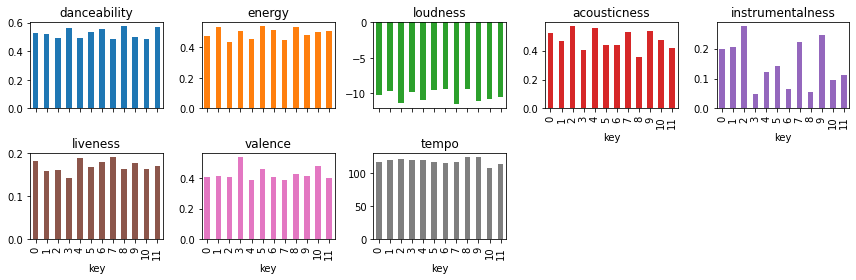

In [ ]:
n=list(df.select_dtypes("number").drop(["key","time_signature"],axis=1).columns)
plotNumericsByTarget(df,"key",nums=n,layout=(2,5),figsize=(12,4))

We can see that the frequency of tracks fluctuate with changes in *key* parameter, potentially indicating that this feature may serve as a valid predictor. 

Therefore, we'll keep it.

Finally, we'll do the same test for  **time signature.**

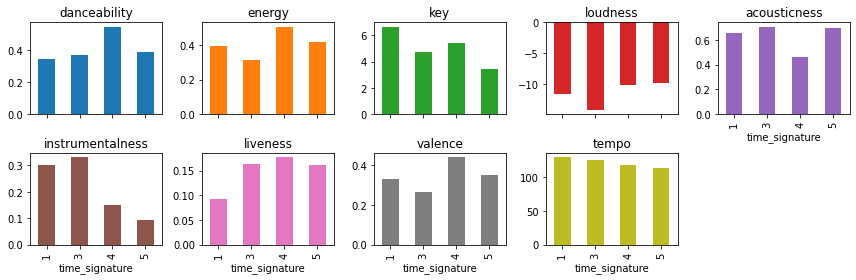

In [ ]:
n=list(df.select_dtypes("number").drop(["time_signature"],axis=1).columns)
plotNumericsByTarget(df,"time_signature",nums=n,layout=(2,5),figsize=(12,4))

**time_signature** also seems important as numbers change for each value.

## Eyeball Evaluation of Min and Max values of Tracks for Each Features

We'll do an eyeball evaluation of the min and max values of tracks for each numeric feature. This will help us to better understand how these values change in our dataset.

The following function returns 5 entries for both min and max values each.

In [ ]:
for c in df.select_dtypes("number").columns:
    df[[c]].sort_values(by=c).head_and_tail_()

danceability
Artist-Song                                                     
André Rieu-Memory - From "Cats"                           0.0638
New World Orchestra-Last of the Mohicans                  0.0671
James Horner-A Gift Of A Thistle                          0.0828
George Frideric Handel-La grande sarabande pour...        0.0842
Lisa Gerrard-Not Yet                                      0.0947
Ezhel-Olay                                                0.8780
Otis Redding-Stand by Me                                  0.8830
Makali-Sur Les Chemins                                    0.8910
Ceza-Neyim Var Ki (feat. Sagopa K)                        0.9040
Katie Melua-Wonderful Life                                0.9040

energy
Artist-Song                                                
George Frideric Handel-Sarabande from Keyboard ...  0.00260
Erik Satie-Gnossienne No. 1                         0.00579
George Frideric Handel-Suite in B-Flat Major, H...  0.00645
Erik Satie-Gnossienne: No. 1                        0.00798
Frédéric Chopin-Nocturnes, Op. 9: No. 1 in B-Fl...  0.00980
Pet Shop Boys-Go West - 2003 Remaster               0.95100
Basshunter-Boten Anna - Radio edit                  0.97100
Infernal-Self Control                               0.97500
Lasgo-Something                                     0.98100
Manian-Like a Prayer - Cascada Radio Edit           0.99400

key
Artist-Song                        
Lana Del Rey-Lucky Ones           0
Ahmet Kaya-Giderim                0
Ahmet Kaya-Acılara Tutunmak       0
Yanni-One Man's Dream             0
Zeki Müren-Sorma Ne Haldeyim      0
Zeki Müren-Gitme Sana Muhtacım   11
Yeni Türkü-Olmasa Mektubun       11
Yedi Karanfil-Gözlerin           11
Grup Yorum-Daglara Gel Daglara   11
U2-Beautiful Day                 11

loudness
Artist-Song                                                 
James Horner-A Gift Of A Thistle                     -36.045
George Frideric Handel-Suite in B-Flat Major, H...   -32.739
George Frideric Handel-Sarabande from Keyboard ...   -32.693
Frédéric Chopin-Nocturnes, Op. 9: No. 1 in B-Fl...   -32.212
Erik Satie-Gnossienne No. 1                          -31.615
Kalwi & Remi-Explosion                                -3.028
Sia-Chandelier                                        -2.880
Benassi Bros.-Every Single Day - Radio Edit           -2.827
Pitbull-Rain Over Me (feat. Marc Anthony)             -2.117
mor ve ötesi-Bir Derdim Var                           -1.988

acousticness
Artist-Song                                                     
Keith Richards-Bittersweet Symphony                     0.000013
Kalwi & Remi-Explosion                                  0.000031
Lady Gaga-Alejandro                                     0.000358
Delerium-Silence - DJ Tiësto's In Search Of Sun...      0.001340
Guns N' Roses-Don't Cry (Original)                      0.001820
George Frideric Handel-Sarabande from Keyboard ...      0.993000
George Frideric Handel-Suite in B-Flat Major, H...      0.994000
Johann Sebastian Bach-Partita No. 1 In B Flat M...      0.994000
Erik Satie-Gnossienne: No. 1                            0.996000
Erik Satie-Gnossienne No. 1                             0.996000

instrumentalness
Artist-Song                                                         
Jubël-Dancing In The Moonlight (feat. NEIMY)                   0.000
Yeni Türkü-Olmasa Mektubun                                     0.000
Yeni Türkü-Yağmurun Elleri                                     0.000
DJ BoBo-Everybody                                              0.000
The Beatles-Hey Jude                                           0.000
Hans Zimmer-Cornfield Chase                                    0.973
George Frideric Handel-Sarabande from Keyboard ...             0.973
Yanni-One Man's Dream                                          0.975
The Robby Cool Orchestra-Forest Gump Main Theme                0.978
Ramin Djawadi-Mako (feat. Priscilla Ahn)                       0.980

liveness
Artist-Song                                                 
Tarkan-Dudu                                           0.0331
Duman-Senden Daha Güzel                               0.0415
John Lennon-Woman - Remastered 2010                   0.0420
Party Tyme Karaoke-Hey Baby (Drop It To The Flo...    0.0437
Pinhani-Hele Bi Gel                                   0.0448
Queen-We Are The Champions - Live Aid                 0.9020
Zülfü Livaneli-Özgürlük - Live                        0.9300
Isgaard-...Where The River Will Flow                  0.9320
Leo Rojas-El Condor Pasa                              0.9420
Bülent Ortaçgil-Sensiz Olmaz                          0.9590

valence
Artist-Song                                           
Ramin Djawadi-Mako (feat. Priscilla Ahn)        0.0341
Priscilla Ahn-Vampire                           0.0355
James Horner-For The Love Of A Princess         0.0362
Lisa Gerrard-Not Yet                            0.0366
André Rieu-Memory - From "Cats"                 0.0369
Yann Tiersen-Les jours tristes - Instrumental   0.9520
The Trouble Notes-Adriano                       0.9560
Camila Cabello-Bam Bam (feat. Ed Sheeran)       0.9560
ABBA-Super Trouper                              0.9610
Madonna-La Isla Bonita                          0.9640

tempo
Artist-Song                                      
New World Orchestra-Last of the Mohicans   49.885
Secret Garden-Adagio                       51.096
Trevor Jones-Promontory                    51.566
Pinhani-Ne Güzel Güldün                    51.722
Gheorghe Zamfir-Time to Say Goodbye        52.983
Makis Ablianitis-Astro krifo              185.699
maNga-Dursun Zaman (feat. Göksel)         185.986
R.E.M.-Everybody Hurts                    188.200
Nazan Öncel-Gitme Kal Bu Şehirde          190.971
Yann Tiersen-La valse d'Amélie            192.073

time_signature
Artist-Song                                                       
Tomaso Albinoni-Adagio in G Minor                                1
Emre Sertkaya-Minnet Eylemem                                     1
Pinhani-Hele Bi Gel                                              1
Mazhar Alanson-Yandım                                            3
Nick Cave & The Bad Seeds-Where the Wild Roses ...               3
George Frideric Handel-La grande sarabande pour...               5
Sia-Chandelier                                                   5
Lana Del Rey-Video Games                                         5
Sezen Aksu-Mia Pista Apo Fosforo / Her Şeyi Yak...               5
Grup Yorum-Drama Köprüsü                                         5

## Checking for null values

In [ ]:
df.isnull().any()

danceability        False
energy              False
key                 False
loudness            False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
time_signature      False
playlist             True
dtype: bool

We only encounter null values in the *playlist* feature, however this is not an issue - we keep the *playlist* feature to verify the outcome of our clustering attemps.

## correlation

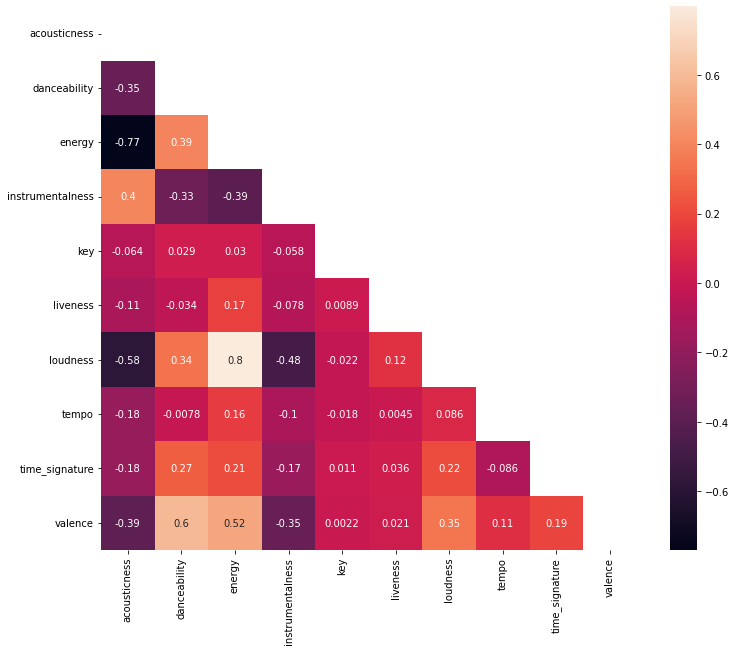

In [ ]:
GetOnlyOneTriangleInCorr(df,None,diagonal=False,heatmap=True)

**Several Observations:**
- There are a few higly correlated features, which is an indicator for us to employ dimension reduction.
- We see that our previous argument regarding *speechiness* gained some merit here, as *instrumentalness* and *speechiness* should be by definition correlated but our Pearson test indicates otherwise. (EDIT: After we removed the speechiness, we are no more able to see it here.)
- We also validate some of our expected scenarios, e.g. *acousticness* and *energy* have a strong negative correlation - which is to be expected.

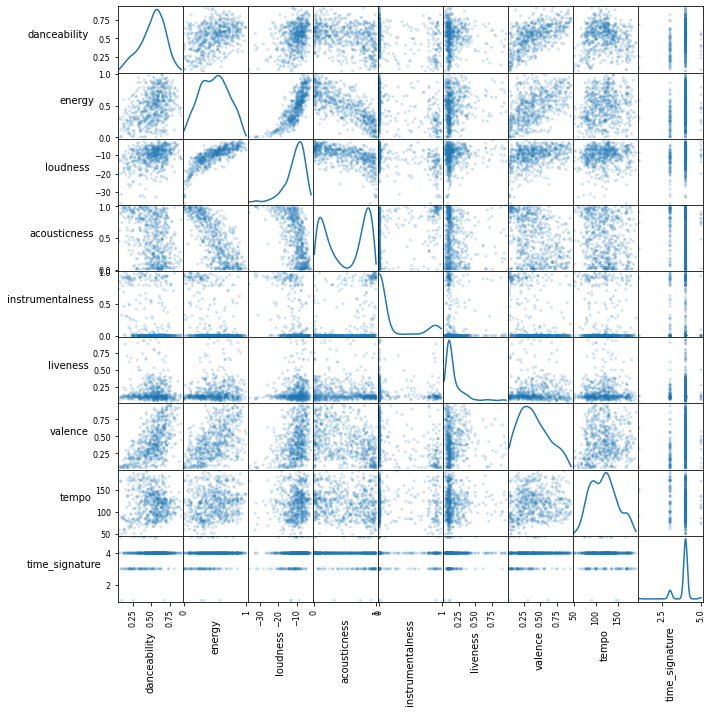

In [ ]:
#scatter matrix
from pandas.plotting import scatter_matrix
axes=scatter_matrix(df.select_dtypes(np.number).drop(["key"],axis=1), alpha=0.2, figsize=(10, 10), diagonal='kde')
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

**Some Observations:**

- Pairwise comparisons show that there is no discernable linear or polynomial correlation between most features.

- As expected, *loudness* and *energy* has a negative linear correlation with *acousticness*, while *loudness* and *energy* seem to have positive polynomial correlation.

- Some features may have issues outliers, as some charts display massive difference between majority of data points and a smaller group of data with almost nothing in between.

## Histograms

Lets plot histograms to check for skewness and outliers

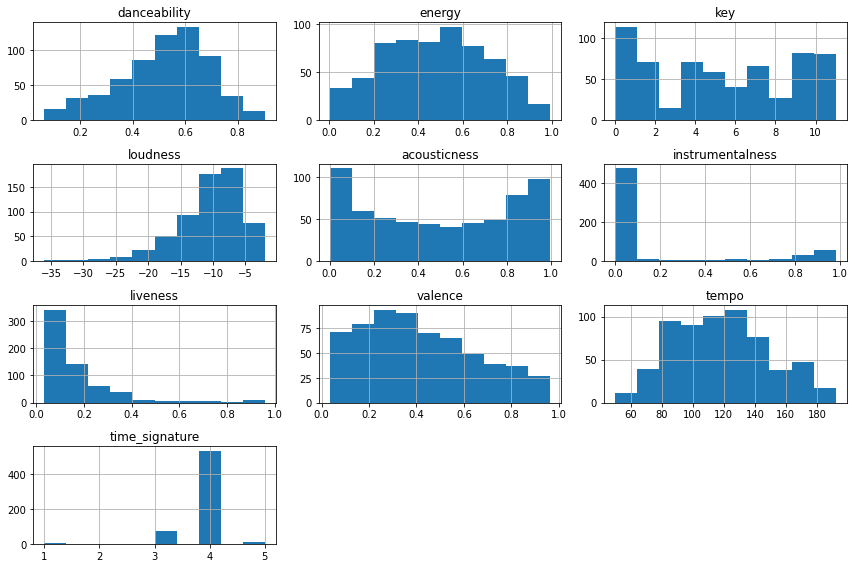

In [ ]:
df.hist(figsize=(12,8))
plt.tight_layout();

**Some Observations:**

- Majority of the data points contain an *instrumentalness* value between zero and one. We believe instead of using a numeric value, we can create a boolean flag to seperate songs as *instrumental* or not, or 3 values like 0,1,2.

- *Liveliness* and *loudness* features has a right/left skewness. As we're going to scale the data, it would be best to do a log transformation before processing.

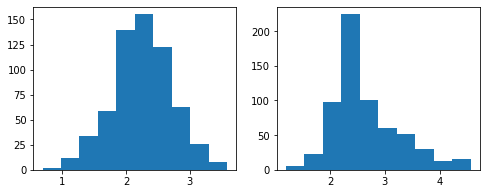

In [ ]:
#Histograms after log transformation of loudness and liveness
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(np.log(np.abs(df.loudness.values)))

plt.subplot(122)
plt.hist(np.log(df.liveness.values*100))

plt.show();

Log transformation seems to have brought the data distribution closer to normal. We'll replace the original data with the log transformed version.

In [ ]:
df.loudness=np.log(np.abs(df.loudness.values))
df.liveness=np.log(df.liveness.values*100)

## outlier check

<Figure size 864x432 with 0 Axes>

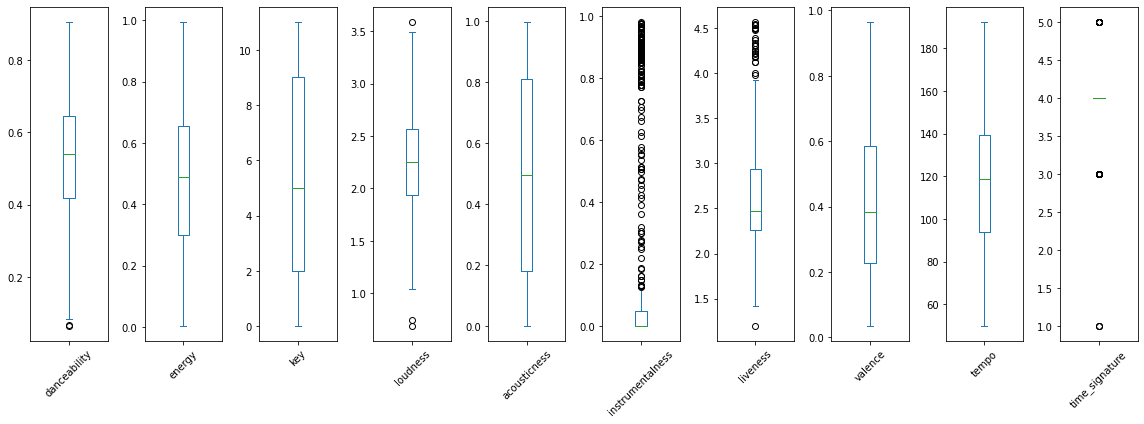

In [ ]:
#now lets check if any outliers exists. since the scales are various, we'll draw charts for each
plt.figure(figsize=(12,6))
df.plot(kind="box", subplots = True,figsize=(16,6),rot=45)
plt.tight_layout()
plt.show();

Let's see how many outliers each feature has:

In [ ]:
#Taking into account that the columns may have several distinct values
outliers_IQR(df,df.drop(["key","playlist"],axis=1).columns,thresh=0.25)

2 outliers exists in feature 'danceability'
3 outliers exists in feature 'loudness'
144 outliers exists in feature 'instrumentalness'
25 outliers exists in feature 'liveness'
90 outliers exists in feature 'time_signature'


We'll split *instrumentalness* into 10 ranges of same distance to gain a better understanding of how these outliers are distributed.

This feature has the highest number of outliers in the dataset, much higher than most other features.

In [ ]:
pd.cut(df["instrumentalness"], 10).value_counts().sort_index()

(-0.00098, 0.098]    475
(0.098, 0.196]        13
(0.196, 0.294]         6
(0.294, 0.392]         6
(0.392, 0.49]          6
(0.49, 0.588]         10
(0.588, 0.686]         4
(0.686, 0.784]        10
(0.784, 0.882]        34
(0.882, 0.98]         58
Name: instrumentalness, dtype: int64

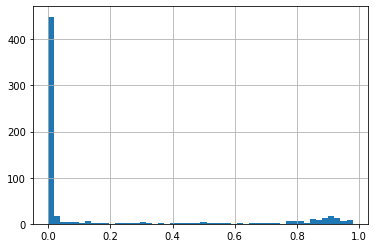

In [ ]:
df["instrumentalness"].hist(bins=50);

Let's get some samples for the sake of a better evaluation.

In [ ]:
df["inst_range"]=pd.cut(df["instrumentalness"], 10).map(str)
df[df["inst_range"]=='(0.098, 0.196]']

danceability  energy  key  \
Artist-Song                                                                     
Yann Tiersen-La valse d'Amélie - Version orchestre         0.195  0.3350    9   
Yann Tiersen-Les jours tristes - Instrumental              0.734  0.3390    7   
Sean Finn-Infinity 2018                                    0.657  0.8130    7   
Hasret Gültekin-Derman Sendedir                            0.616  0.5770    9   
Karl Jenkins-Adiemus                                       0.295  0.4080    4   
John Lennon-Imagine - Remastered 2010                      0.547  0.2570    0   
Murda-AYA                                                  0.743  0.6800    5   
Ayten Alpman-Ben Böyleyim                                  0.405  0.4090    5   
Eric Clapton-Wonderful Tonight                             0.572  0.2140    7   
Deeperise-Uzun Uzun (feat. Jabbar)                         0.725  0.5990    9   
Madonna-Hung Up                                            0.649  0.6470    9   
Georges Bizet-Carmen Suite No. 2: Habanera. All...         0.425  0.0928    7   
Francesco Geminiani-Concerto Grosso No. 12 in D...         0.215  0.3250    1   

                                                    loudness  acousticness  \
Artist-Song                                                                  
Yann Tiersen-La valse d'Amélie - Version orchestre  2.161137        0.8520   
Yann Tiersen-Les jours tristes - Instrumental       2.094700        0.8070   
Sean Finn-Infinity 2018                             1.410011        0.0300   
Hasret Gültekin-Derman Sendedir                     2.470977        0.7630   
Karl Jenkins-Adiemus                                2.811329        0.8040   
John Lennon-Imagine - Remastered 2010               2.514304        0.9070   
Murda-AYA                                           1.468796        0.1130   
Ayten Alpman-Ben Böyleyim                           2.438950        0.9450   
Eric Clapton-Wonderful Tonight                      2.748872        0.6490   
Deeperise-Uzun Uzun (feat. Jabbar)                  2.193440        0.5840   
Madonna-Hung Up                                     2.040571        0.0039   
Georges Bizet-Carmen Suite No. 2: Habanera. All...  3.060255        0.9250   
Francesco Geminiani-Concerto Grosso No. 12 in D...  2.456164        0.5160   

                                                    instrumentalness  \
Artist-Song                                                            
Yann Tiersen-La valse d'Amélie - Version orchestre             0.131   
Yann Tiersen-Les jours tristes - Instrumental                  0.186   
Sean Finn-Infinity 2018                                        0.103   
Hasret Gültekin-Derman Sendedir                                0.128   
Karl Jenkins-Adiemus                                           0.148   
John Lennon-Imagine - Remastered 2010                          0.183   
Murda-AYA                                                      0.123   
Ayten Alpman-Ben Böyleyim                                      0.162   
Eric Clapton-Wonderful Tonight                                 0.129   
Deeperise-Uzun Uzun (feat. Jabbar)                             0.149   
Madonna-Hung Up                                                0.161   
Georges Bizet-Carmen Suite No. 2: Habanera. All...             0.127   
Francesco Geminiani-Concerto Grosso No. 12 in D...             0.101   

                                                    liveness  valence  \
Artist-Song                                                             
Yann Tiersen-La valse d'Amélie - Version orchestre  2.459589    0.252   
Yann Tiersen-Les jours tristes - Instrumental       2.080691    0.952   
Sean Finn-Infinity 2018                             3.508556    0.142   
Hasret Gültekin-Derman Sendedir                     2.572612    0.742   
Karl Jenkins-Adiemus                                2.803360    0.164   
John Lennon-Imagine - Remastered 2010               2.235376    0.169   


Spotify suggests using the value of 0.5 to seperate how *instrumental* a song is. However, we suspect there may be some songs that were not correctly tagged by Spotify due some of the anomalies we've mentioned in the previous sections. 

In our case, the majority of our outliers are above the **0.7** levels, which we'll use as our threshold.

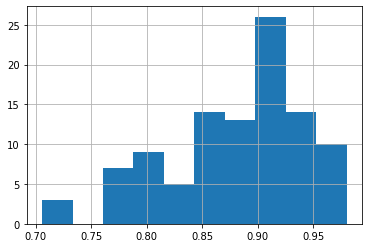

In [ ]:
df[df.instrumentalness>0.7]["instrumentalness"].hist();

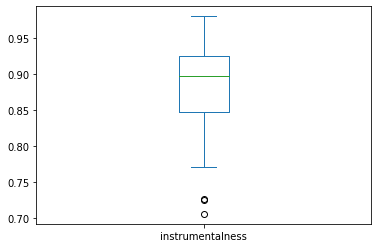

In [ ]:
df[df.instrumentalness>0.7]["instrumentalness"].plot.box();

Further look into outliers of *instrumentalness*, we note that what we're dealing here is not a case of outliers, but effectively having two different categories containing songs grouped together.

So, instead of considering *instrumentalness* as a numeric value, using it as a flag would make better sense.

As this flag would infer ordinality (like t-shirt sizes, but for instrumentalness of a song), we will also not be one hot encoding this feature when preparing our data for modeling.

In [ ]:
df["DegreeofInstrumentality"]=np.where(df.instrumentalness>0.7,2,np.where(df.instrumentalness>0.01,1,0))

In [ ]:
df["DegreeofInstrumentality"].value_counts()

0    442
2    101
1     79
Name: DegreeofInstrumentality, dtype: int64

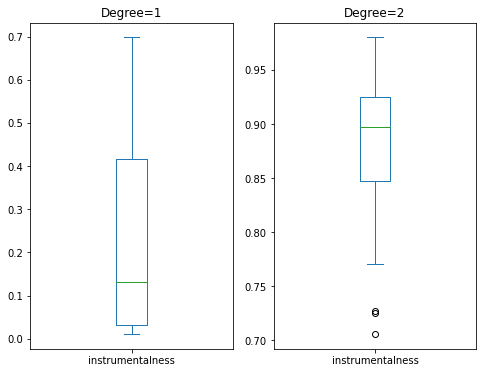

In [ ]:
#Checking if our transformation made sense

plt.figure(figsize=(8,6))
ax1=plt.subplot(121)
ax1=df[df.DegreeofInstrumentality==1]["instrumentalness"].plot.box()
ax1.set_title("Degree=1")

ax1=plt.subplot(122);
ax2=df[df.DegreeofInstrumentality==2]["instrumentalness"].plot.box()
ax2.set_title("Degree=2")

plt.show();

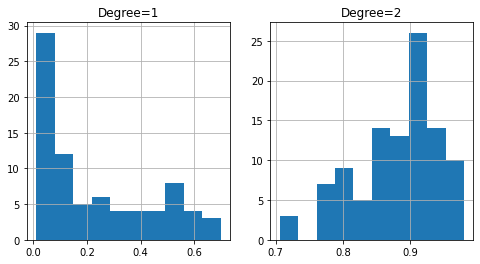

In [ ]:
plt.figure(figsize=(8,4))
ax1=plt.subplot(121)
ax1=df[df.DegreeofInstrumentality==1]["instrumentalness"].hist()
ax1.set_title("Degree=1")

ax1=plt.subplot(122);
ax2=df[df.DegreeofInstrumentality==2]["instrumentalness"].hist()
ax2.set_title("Degree=2")

plt.show();

We see a much better distribution and outliers are no longer impacting the data.

A quick look into other features with outliers - *time_signature* and *liveliness* - shows that we may not need a similar transformation for them as the outliers are both low in number and are not distributed in such a specific pattern.

In [ ]:
#Removing the original numeric "instrumentalness" feature to avoid multicollinearity issues
del df["instrumentalness"]

In [ ]:
df.head()

danceability  energy  key  \
Artist-Song                                                               
Jubël-Dancing In The Moonlight (feat. NEIMY)         0.659   0.615   11   
Camila Cabello-Bam Bam (feat. Ed Sheeran)            0.756   0.697    8   
Sia-1+1                                              0.862   0.641    0   
Jabbar-Aldatıldık                                    0.767   0.658    9   
Sia-Unstoppable                                      0.468   0.779    9   

                                              loudness  acousticness  \
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)  1.769002         0.270   
Camila Cabello-Bam Bam (feat. Ed Sheeran)     1.852698         0.182   
Sia-1+1                                       1.413180         0.120   
Jabbar-Aldatıldık                             2.183013         0.511   
Sia-Unstoppable                               1.576708         0.112   

                                              liveness  valence    tempo  \
Artist-Song                                                                
Jubël-Dancing In The Moonlight (feat. NEIMY)  2.928524    0.193  119.843   
Camila Cabello-Bam Bam (feat. Ed Sheeran)     3.505557    0.956   94.996   
Sia-1+1                                       3.514526    0.674  109.998   
Jabbar-Aldatıldık                             2.379546    0.713   95.001   
Sia-Unstoppable                               2.312535    0.260  173.799   

                                              time_signature playlist  \
Artist-Song                                                             
Jubël-Dancing In The Moonlight (feat. NEIMY)               4      NaN   
Camila Cabello-Bam Bam (feat. Ed Sheeran)                  4      NaN   
Sia-1+1                                                    4      NaN   
Jabbar-Aldatıldık                                          4      NaN   
Sia-Unstoppable                                            4      NaN   

                                                     inst_range  \
Artist-Song                                                       
Jubël-Dancing In The Moonlight (feat. NEIMY)  (-0.00098, 0.098]   
Camila Cabello-Bam Bam (feat. Ed Sheeran)     (-0.00098, 0.098]   
Sia-1+1                                       (-0.00098, 0.098]   
Jabbar-Aldatıldık                             (-0.00098, 0.098]   
Sia-Unstoppable                               (-0.00098, 0.098]   

                                              DegreeofInstrumentality  
Artist-Song                                                            
Jubël-Dancing In The Moonlight (feat. NEIMY)                        0  
Camila Cabello-Bam Bam (feat. Ed Sheeran)                           0  
Sia-1+1                                                             0  
Jabbar-Aldatıldık                                                   0  
Sia-Unstoppable                                                     0

# Clustering

In this section, we'll attempt to find groups of songs that are similar. This will help us determine the song-playlist mapping in the next section.

We'll evaluate different ways for preprocessing the data and different clustering algorithms to find the most suitable one.

## Scaling

In our EDA studies, we had seen that our features have a variety of scales / ranges. Therefore, we'll need to scale our data before applying any clustering method.

We'll evaluate the following scalers:


*   MinMaxScaler
*   StandardScaler
*   RobustScaler

Our initial hypothesis is that to handle the existence of outliers, our best bet would be using the **RobustScaler** as it is *robust* against outliers.

However, we'll use the scientific method of trial-and-error to determine which works best with our current dataset.

In [ ]:
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
ms=MinMaxScaler()
rs=RobustScaler()
ss=StandardScaler()

X=df.select_dtypes("number")
X_ms=ms.fit_transform(X)
X_rs=rs.fit_transform(X)
X_ss=ss.fit_transform(X)

In [ ]:
#CONVERT TO DF AGAIN FOR NAMING COLUMNS
X_ms = pd.DataFrame(X_ms, columns=X.columns)
X_rs = pd.DataFrame(X_rs, columns=X.columns)
X_ss = pd.DataFrame(X_ss, columns=X.columns)

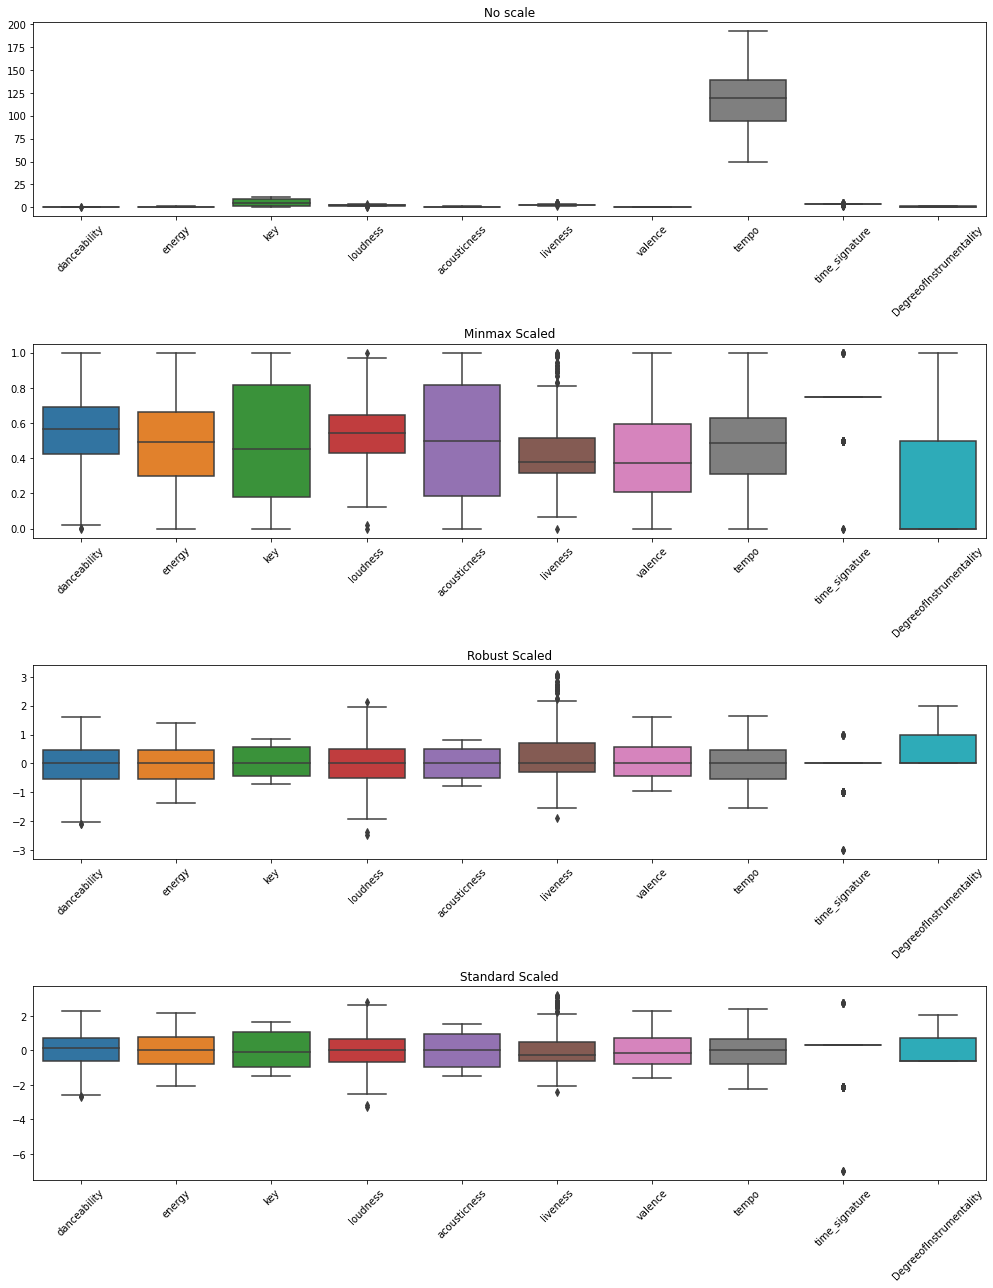

In [ ]:
plt.figure(figsize=(14,18))
ax1=plt.subplot(411)
ax1=sns.boxplot(data=X)
ax1.set_title("No scale")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

ax2=plt.subplot(412)
ax2=sns.boxplot(data=X_ms)
ax2.set_title("Minmax Scaled")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)

ax3=plt.subplot(413)
ax3=sns.boxplot(data=X_rs)
ax3.set_title("Robust Scaled")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)

ax4=plt.subplot(414)
ax4=sns.boxplot(data=X_ss)
ax4.set_title("Standard Scaled")
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=45)

plt.tight_layout()
plt.show();

**Eyeball Evaluation of Scalers**

1. **No Scale:** Once again, we can clearly see that the data ranges are not suitable for clustering as features with higher ranges / values will weigh higher in the decision process of the clustering algorithm.

2. **MinMaxScaler:** We can see that the values of the features are scaled to a similar level, yet we can still see some small differences in ranges. As we want our features to have the same level of influence, this may be a potential issue.

3. **RobustScaler:** We can now see a more uniform range among the different features, while handling the outliers up to a point. This seems preferable to first two options.

4. **StandardScaler:** This scaler performed as we expected - when features were standardized, we obtained a much more preferred results - which is very similar to the outcome of the *RobustScaler*. We believe this could also be one of the best options.

## PCA

As we mentioned in our EDA studies, several features had high correlation values, signalling the potential for dimension reduction.

We'll evaluate PCA as a method for dimension reduction and check the explained variance ratio to make sure that we don't lose pertinent information.

In [ ]:
from sklearn.decomposition import PCA

for nc in [2, 0.95]:
    for s in [X_ms, X_rs, X_ss]:
        pca = PCA(n_components=nc, random_state=42)
        X_pca = pca.fit_transform(s)
        print(pca.n_components_, ",",sum(pca.explained_variance_ratio_))

2 , 0.5596711342261101
2 , 0.5338168544418285
2 , 0.47155490520962107
8 , 0.9779597286478481
8 , 0.9604730299589932
8 , 0.9516818038238041


With 2 features, we cover less than half of the information. 

In order to ensure at least 95% of the data is explained, we'll need to use 8 of our features. 

As we already have 10 relevant features, PCA does not seem like a good idea. 

With 8 features, we wont be able to visualize the results for an eyeball test either.

As a matter of fact, we'd better use t-SNE rather than PCA for visualizing. (see https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0)

## Clustering Tendency Evaluation

###  Eyeball test with t-SNE i

We'll apply **tSNE** to better visualize the multidimensional dataset.

First, we'll plot each scaled dataset to better understand how they look and perform a basic eyeball evaluation on the data could be clustered.

In [ ]:
%mgc_suppresswarning FutureWarning

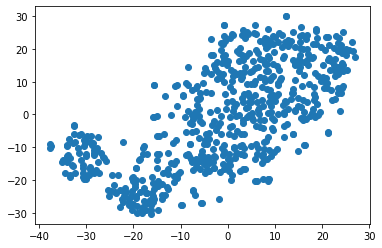

In [ ]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_ss)
plt.scatter(X_tsne[:,0],X_tsne[:,1]);

**StandardScaled:** We can see that there could be two small and one large clusters that could be considered *seperable*.

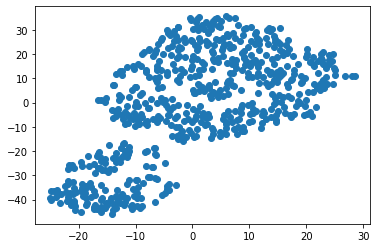

In [ ]:
X_tsne = tsne.fit_transform(X_ms)
plt.scatter(X_tsne[:,0],X_tsne[:,1]);

**MinMaxScaler:** We can see about 2-4 small clusters on the top-right, with a single large one on the bottom left. Seperability seems better than *StandardScaler*.

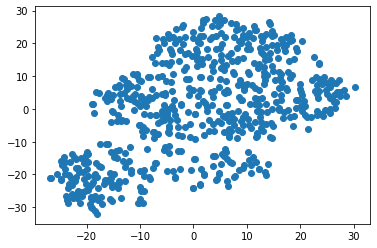

In [ ]:
X_tsne = tsne.fit_transform(X_rs)
plt.scatter(X_tsne[:,0],X_tsne[:,1]);

**RobustScaler:** Like StandardScaler, seperability is not visible in this case.

**Result:**

Best seperability appears to exist in the *MinMaxScaler* applied dataset when evaluated with an eyeball test. We could easily identify 2-4 different clusters.

On the other hand, as the owner of this track list, *Volkan* prefers 8-10 different clusters - as is the real life scenario.

In our future work, we'll consider k = 8 in the parameter space.

### Hopkins Test

*Hopkins Statistic* is used to evaluate the clustering tendency of a dataset.

We'd like to attempt to validate our assumptions from the eyeball test with a statistics test to make sure we're not making unrealistic claims.

Below is the *Hopkins statistic* for each scaled dataset in the following order:

* MinMaxScaler
* RobustScaler
* StandardScaler

In [ ]:
CheckForClusteringTendencyWithHopkins(X_ms,42)

0.6919214676997223

In [ ]:
CheckForClusteringTendencyWithHopkins(X_rs,42)

0.6992318412591638

In [ ]:
CheckForClusteringTendencyWithHopkins(X_ss,42)

0.7132144899752615

*Hopkins statistic* for each of these datasets are quite close. 

Our eyeball test claimed that *MinMaxScaler* dataset would present the best opportunity for clustering, however in this case it didn't have the highest score.

However, scores for each option are very close and they all can be tried out.

## Creating the Models

### KMeans

Our K-Means clustering efforts can be summarized in the following steps:

1. Draw an *Elbow Plot* to determine the possible *k* values for each scaled dataset.

2. Identify clusters for each dataset using the K-Means Clustering algorithm.

3. Evaluate the results.

#### Deciding the k number of clusters

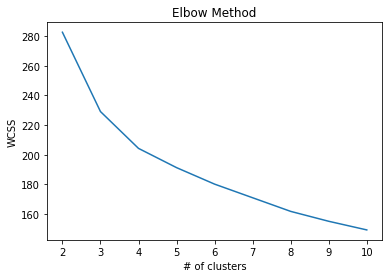

In [ ]:
#MinMaxScaler
cls = range(2,11) #possible number of clusters
draw_elbow(cls,X_ms)

**k value for MinMaxScaler:** 3 and 4 appear to be possible values.

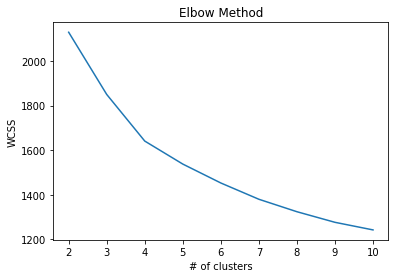

In [ ]:
#RobustScaler
draw_elbow(cls,X_rs)

**k value for RobustScaler:** 4 and 7 appear to be good candidates.

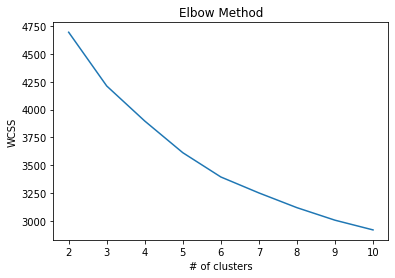

In [ ]:
#StandardScaler
draw_elbow(cls,X_ss)

**k value for StandardScaler dataset:** It is difficult to identify a good value but [3,5,6,9] appear to be viable candidates.

##### Evaluating Potential *k* Values

*Elbow Method* helps us decide a good *k* number for K-Means clustering.

However, our dataset vs. resource capacity presents an opportunity for us to test each *k* within our range by applying the clustering and observing the changes in the *Silhouette Score*.

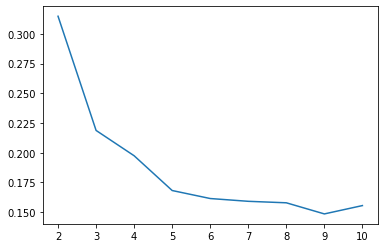

In [ ]:
draw_sihoutte(cls,X_ms,True,False) 

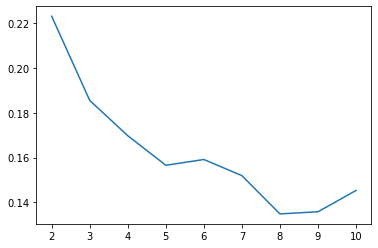

In [ ]:
draw_sihoutte(cls,X_rs,True,False) 

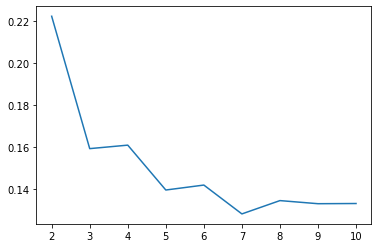

In [ ]:
draw_sihoutte(cls,X_ss,True,False) 

**Evaluation of the Silhouette Score Test**

Either our datasets or K-Means algorithm may not be optimal for our clustering attempt. *Silhouette Score* for each trial is low from the start and keeps falling as we increase the number of clusters.

Obviously, *Silhouette Score* is not a definitive measure but it acts as an indicator. We may need to work on the data more to get better results.

**NEXT: Eyeball Test for each k with dimension reduction**

In order to better understand how our data is seperated, we'll apply PCA to reduce the dimensions to two and do an eyeball evaluation on how the data is clustered in the previous experiment.

Once again, we'll use the *k* range of (2,10) and apply K-Means Clustering algorithm on *MinMaxScaler* dataset.

For n_clusters = 2 The average silhouette_score is : 0.43024536056843654


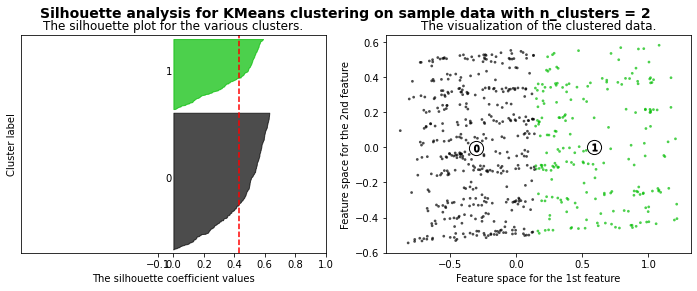

For n_clusters = 3 The average silhouette_score is : 0.37992370644839324


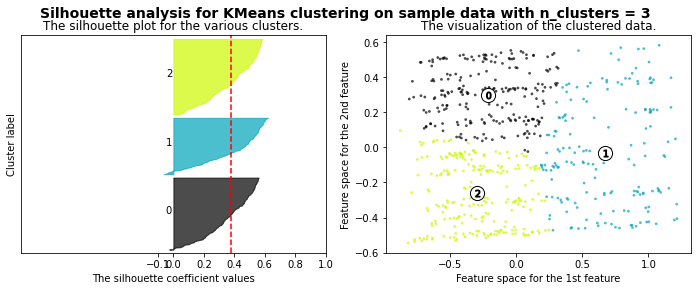

For n_clusters = 4 The average silhouette_score is : 0.3793283431369946


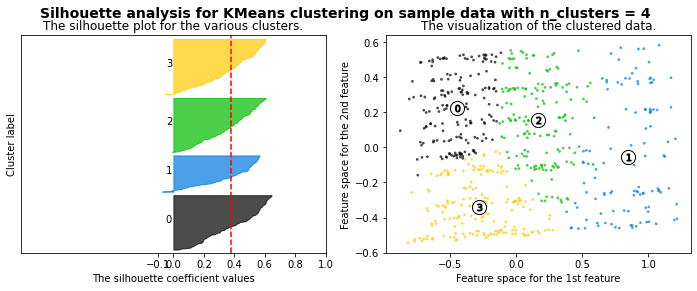

For n_clusters = 5 The average silhouette_score is : 0.37961852063131657


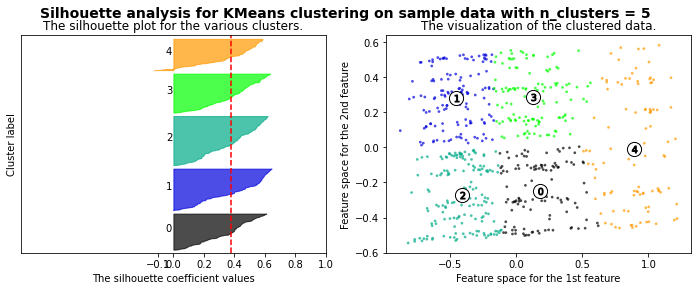

For n_clusters = 6 The average silhouette_score is : 0.3919657827305214


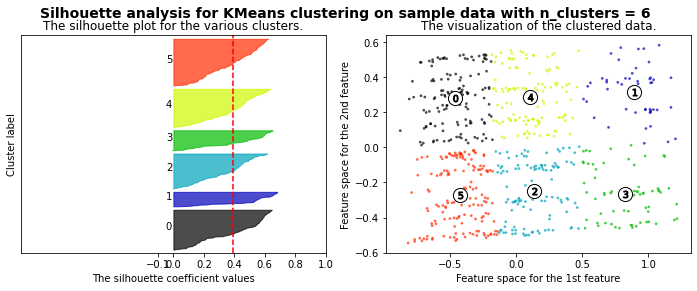

For n_clusters = 7 The average silhouette_score is : 0.3871029479512915


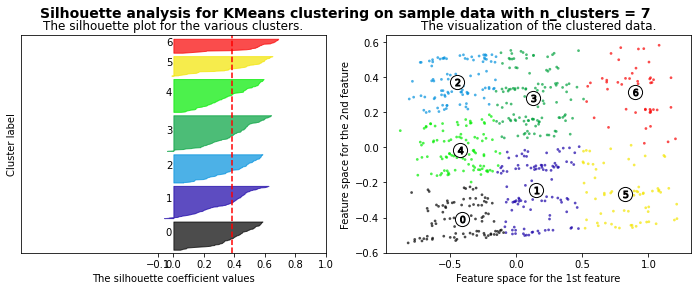

For n_clusters = 8 The average silhouette_score is : 0.38436975050498395


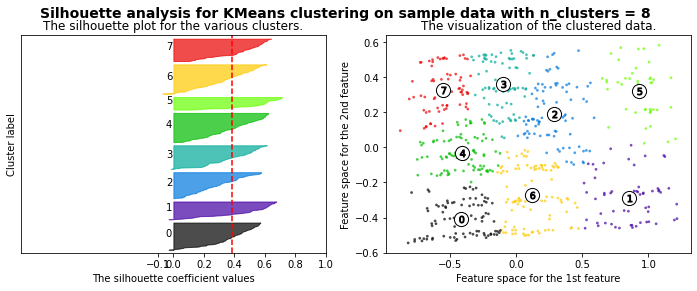

For n_clusters = 9 The average silhouette_score is : 0.3857594978995505


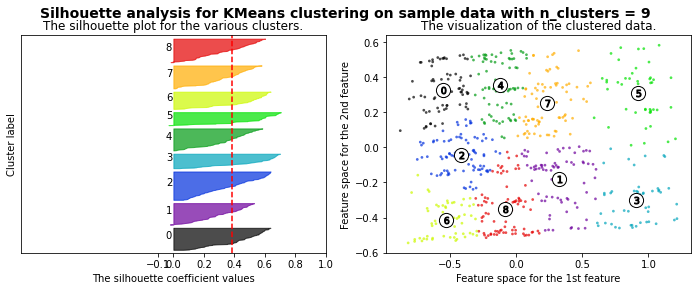

For n_clusters = 10 The average silhouette_score is : 0.3992649584515623


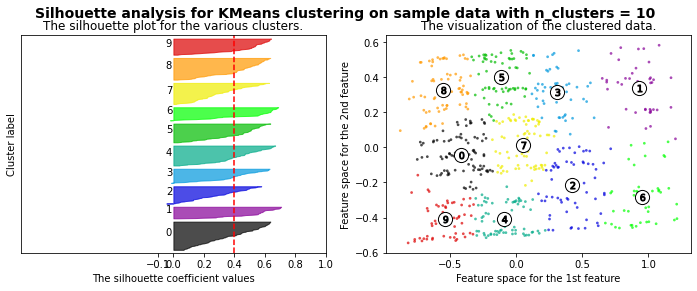

Best score is 0.43024536056843654 for 2


In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_ms)
draw_sihoutte(cls,X_pca,False,False) 

Best option still seems to be *k* = 2, however we know from our business knowledge that it should be more.

During our EDA study, we had noticed that applying PCA would help us better visualize but also cost us relevant information.

Therefore, we'll once again use our *draw_silhouette()* function without applying PCA to better understand how we can select the optimal *k* value. (This time, plots on the right block should be disregarded)

For n_clusters = 2 The average silhouette_score is : 0.3149482243079907


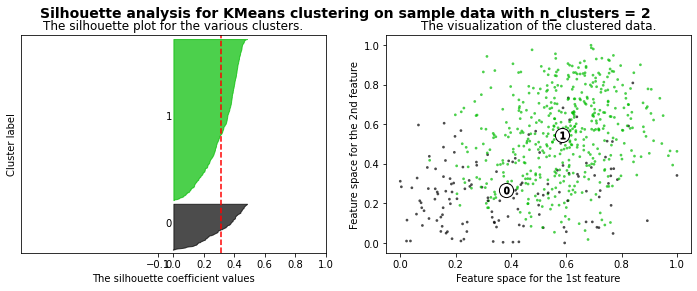

For n_clusters = 3 The average silhouette_score is : 0.21872408667366364


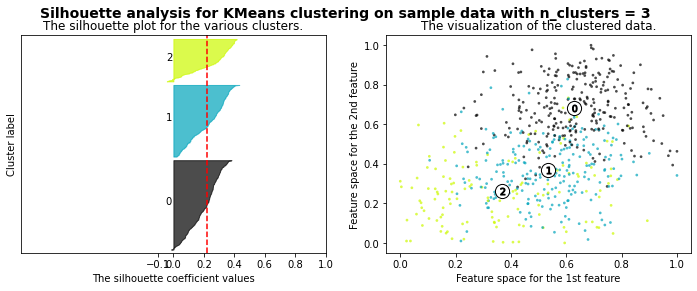

For n_clusters = 4 The average silhouette_score is : 0.19738945921261777


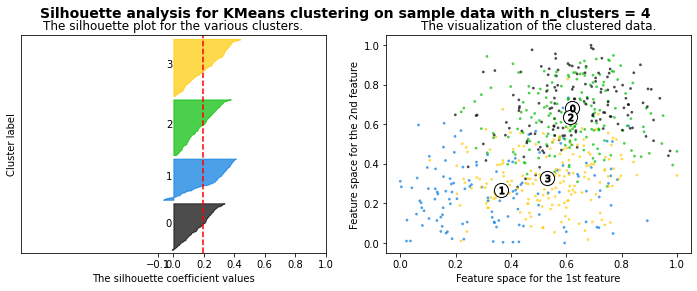

For n_clusters = 5 The average silhouette_score is : 0.16809732905648317


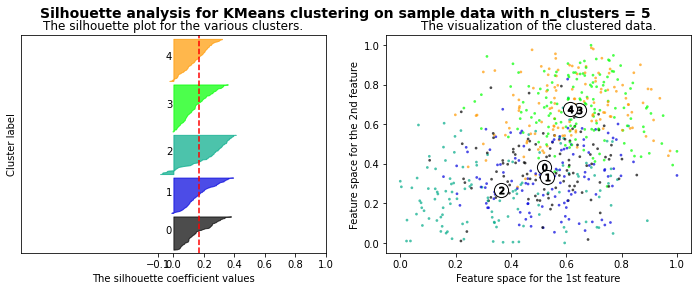

For n_clusters = 6 The average silhouette_score is : 0.16135468310539638


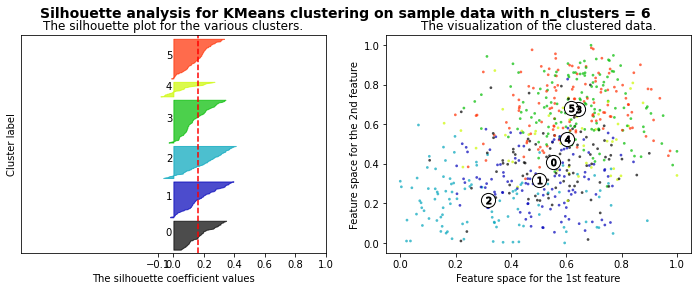

For n_clusters = 7 The average silhouette_score is : 0.15900602674039271


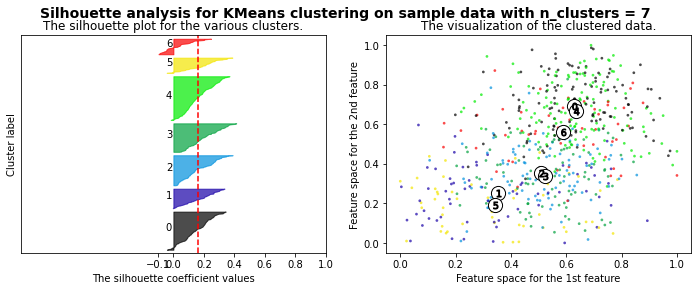

For n_clusters = 8 The average silhouette_score is : 0.15775232880355403


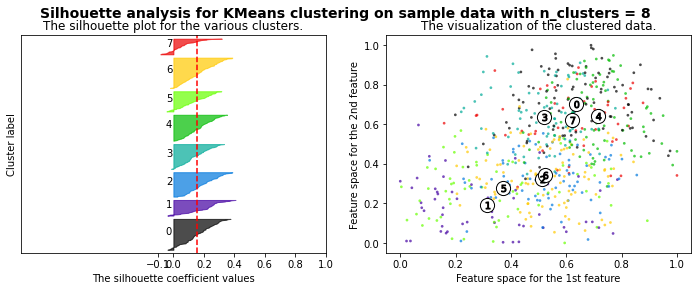

For n_clusters = 9 The average silhouette_score is : 0.14838476198938036


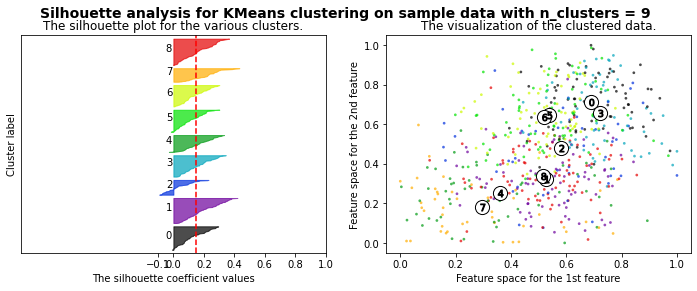

For n_clusters = 10 The average silhouette_score is : 0.1554081028297031


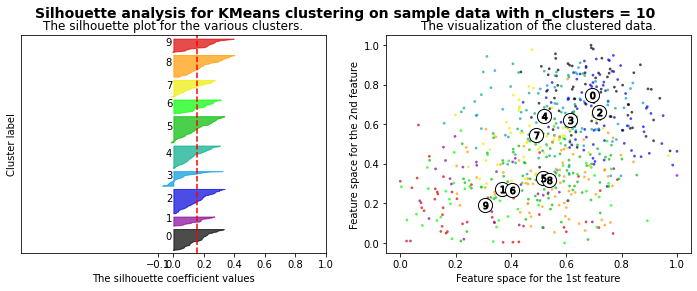

Best score is 0.3149482243079907 for 2


In [ ]:
draw_sihoutte(cls,X_ms.values,False,False) 

**Final Evaluation of our *k* value determination attempts**

Values within our potential *k* range have very similar silhouette scores. Therefore, we can try all of them in our clustering models.

#### Applying the Model

We want **instrumentalness** and **loudness** to be more decisive/effective in forming the clusters, we'll adjust their weights. 

We've discovered some  literature where there are some analytic methods to supply weights(\*) but we prefer to use simple way by just multiplying them with some scalars. 

For further study on how weights can be adjusted, see below:

- https://www.matec-conferences.org/articles/matecconf/pdf/2018/91/matecconf_eitce2018_03005.pdf
- https://link.springer.com/article/10.1007/s10994-016-5623-3

In [ ]:
w=np.ones(10)
w[[3,9]]=2 #degreeofinstrumental and loudness
w

array([1., 1., 1., 2., 1., 1., 1., 1., 1., 2.])

In [ ]:
X_ms_weighted=X_ms.values*w

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ms_weighted)

KMeans(n_clusters=4)

In [ ]:
kmeans.labels_.valuecounts_()

array([[  0, 196],
       [  1, 101],
       [  2, 246],
       [  3,  79]], dtype=int64)

**Evaluation of our K-Means Clustering Model**

We selected *MinMaxScaler* dataset for our final model and chose *k* = 4 based on our evaluation of the *Elbow Plot*.

Based on our business case, we were hoping to see a larger number of clusters, however our previous work shows us that we do not get better seperated groups with a higher *k* value.

Looking at the value counts, we obtained a result similar to the one we expected in our eyeball test - one relatively large cluster with 3 smaller ones.

Next, we'll try to shed some light into *why* the data was seperated into *these* four clusters.

#### Explaining the results

To explain the clustering result better, we will fit a classifier model whose output matches the same labels provided by the clustering and compute SHAP values based on this classifier model.

We will be using the *Random Forest Classifier*. As there is no need to do scaling before fitting a *Random Forest Classifier*, we can use the original data directly. 

Since the goal of the classifier is to better understand the clustering and there is no issue of overfitting, we will use all the datasets to do the fit.

For the sake of explianability and other reasons mentioned above, we will not apply PCA.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=42)
clf.fit(X_ms_weighted,kmeans.labels_)

RandomForestClassifier(random_state=42)

In [ ]:
%mgc_suppresswarning DeprecationWarning

 98%|===================| 2450/2488 [01:03<00:00]        

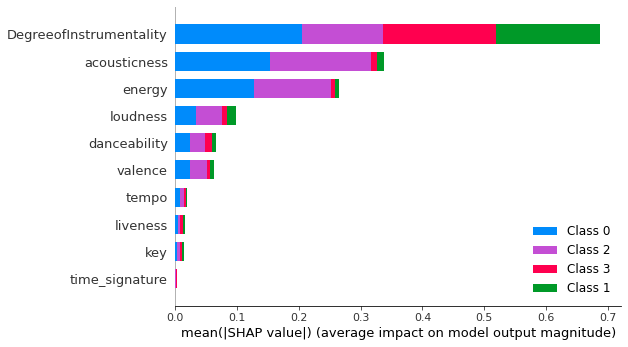

In [ ]:
import shap
explainer= shap.TreeExplainer(clf, data=X_ms_weighted, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_ms_weighted,check_additivity=False)
shap.summary_plot(shap_values, X_ms_weighted, X.columns)

We leave the explaining the chart to final model part.

### DBSCAN

We'll use our *Epsilon Decider* function to find the ideal range of values for each dataset.

Let's assume min_samples = 10 as Volkan prefers at least 10 tracks to be in a playlist. 

On the other hand, one of the wide-spread view is to multipy the number of features with 2. So we can also include the number 20 in the paramgrid. 

In the following plots we'll take only 10.

**Determining eps values**

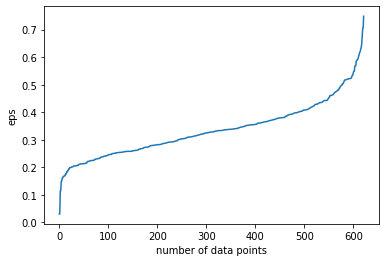

In [ ]:
k=11 #(10+1)
drawEpsilonDecider(X_ms_weighted,k)

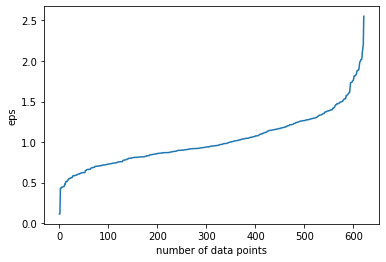

In [ ]:
X_rs_weighted=X_rs*w
drawEpsilonDecider(X_rs_weighted,k)

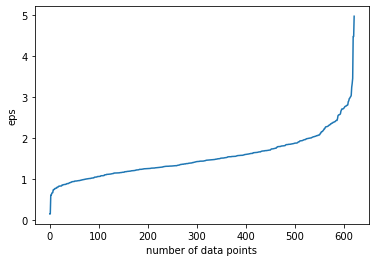

In [ ]:
X_ss_weighted=X_ss*w
drawEpsilonDecider(X_ss_weighted,k)

We notice that for each dataset, the edge of the bend is at different eps levels. Therefore, we can choose the following values to evaluate: [0.5, 1, 1.5, 2]

### Model Selection with ParameterGrid

ParameterGrid is GridSearch's unsupervised version. More info is <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html">here.</a>

#### Feature Selection

##### Manuel Check via Business Case

We already removed some of the features above. 

As for multicollinearity, we cant see any in the correlation list, so no need to remove any more fatures.

##### Variance Threshold

In [ ]:
#We can't use standard scaler here, as we need the different variances to exist
np.var(X_ms_weighted,axis=0)

array([0.04059539, 0.05546025, 0.10166579, 0.10690867, 0.11052024,
       0.03174015, 0.06661332, 0.04617466, 0.01057035, 0.57243256])

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
sel.fit(X_ms_weighted)
list(zip(X.columns,sel.get_support()))

VarianceThreshold(threshold=0.05)

[('danceability', False),
 ('energy', True),
 ('key', True),
 ('loudness', True),
 ('acousticness', True),
 ('liveness', False),
 ('valence', True),
 ('tempo', False),
 ('time_signature', False),
 ('DegreeofInstrumentality', True)]

We'll add these features above to the following method's outcome:

In [ ]:
VT_idx=[e for e,x in enumerate(sel.get_support()) if x]
VT_idx

[1, 2, 3, 4, 6, 9]

##### Random greedy approach

In [ ]:
#We'll create a combination of all feature spaces, except one which will be added manually later
from itertools import combinations
comb_list=[]
for i in range(2,10):
    combs=combinations(X.columns,i)
    comb_list.extend(combs)

In [ ]:
#Let's choose 40 different combinations of features
np.random.seed(42)
n=40
features_list=np.random.choice(np.array(comb_list,dtype="object"),size=n,replace=False) 

In [ ]:
#Ensuring "loudness" and "instrumentalness" is in the feature list
features_list_final=[]
for f in features_list:
    if 'loudness' not in f:
        f=[x for x in f]+['loudness']
    if 'DegreeofInstrumentality' not in f:
        f=[x for x in f]+['DegreeofInstrumentality']
    features_list_final.append(f)

In [ ]:
len(features_list_final)

40

In [ ]:
#Checking to make sure full list is included
if features_list_final.getLongestInnerList_()[1]<9:
    features_list_final.append(X.columns)

In [ ]:
features_list_final_colindex=[[list(X.columns).index(y) for y in x] for x in features_list_final]    

In [ ]:
len(features_list_final_colindex)

40

In [ ]:
#Making sure that the variance threshold output is added
if VT_idx not in features_list_final_colindex:
    features_list_final_colindex.append(VT_idx)

In [ ]:
len(features_list_final_colindex)

41

#### Model Selection

In this section, we'll try to select the best hyperparameters and the clustering algorithm.

We'll include all scalers, along with *K-Means*, *DBScan* and *Agglomerative* clustering algorithms.

We did not see the need to do a seperate section for *Agglomerative Clustering*, instead we'll evaluate it here using our learnings from our previous work.

We'll evaluate each of these trials with the *Silhouette Score*, *Calinski Harabasz Score* and *Davie Bouldin Score*. Decision criteria will be custom score we generated by multiplying / dividing (for *Davie Bouldin*) the scores with each other. 

In [ ]:
from sklearn.model_selection import ParameterGrid
scalers=[StandardScaler(),RobustScaler(),MinMaxScaler()]
weights=[1, 1.5] #degreeofinstrumental and loudness weights   
param_grid = [
             {'scl':scalers, 'nc':[4,8], 'max_iter':[50,100], 'n_init':[3,10],'wgh':weights}, #KMeans
             {'scl':scalers, 'eps': [0.5, 1, 1.5, 2], 'min_samples': [10,20],'wgh':weights}, #DBSCAN             
             {'scl':scalers, 'nc':[4,8], 'linkage': ["ward","single","average","complete"],'wgh':weights} #Agglomerative             
             ]
#Number of combinations of this param_grid values
len(ParameterGrid(param_grid))

144

In [ ]:
%%time
from multiprocessing import Pool
from tqdm.notebook import tqdm
from spotify_parallel import run_grid_parallel

Xs=[X]*len(features_list_final_colindex)
param_grids=[param_grid]*len(features_list_final_colindex)
inputs = zip(features_list_final_colindex, param_grids, Xs)
if __name__ == '__main__':
    with Pool() as p:
        r = list(tqdm(p.imap(run_grid_parallel, inputs), total=len(features_list_final_colindex)))            


Wall time: 29min 47s


In [ ]:
#Consolidating the results into a final dataframe
finaldf=pd.concat(r,axis=0,ignore_index=True) #except for the last column, which are labels
finaldf.shape

(5096, 7)

In [ ]:
finaldf["final"]=finaldf.silhoute*finaldf.calinski_harabasz*(1/finaldf.davie_bouldin) #Davie-Bouldin scoring is inversely proportional
finaldf.drop("labels",axis=1).sort_values("final",ascending=False).head()

Cols    Algo  \
2372  (1, 5, 8, 3, 9)  KMeans   
2348  (1, 5, 8, 3, 9)  KMeans   
2384  (1, 5, 8, 3, 9)  KMeans   
2360  (1, 5, 8, 3, 9)  KMeans   
1134     (0, 4, 9, 3)  KMeans   

                                                 params  silhoute  \
2372  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.385496   
2348  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.385496   
2384  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.385425   
2360  {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.385425   
1134  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.420884   

      calinski_harabasz  davie_bouldin       final  
2372         823.071514       0.960130  330.466195  
2348         823.071514       0.960130  330.466195  
2384         823.093879       0.960127  330.415328  
2360         823.093879       0.960127  330.415328  
1134         751.241229       0.973540  324.779115

**Initial Evaluation**

We noticed that we were not able to improve our scores much compared to our previous work. 

**Next:** We're hoping to improve our results by better tuning our model by narrowing the parameter space down to the best performing values.

In [ ]:
finaldf.drop("labels",axis=1).sort_values("final",ascending=False).head(20)

Cols           Algo  \
2372  (1, 5, 8, 3, 9)         KMeans   
2348  (1, 5, 8, 3, 9)         KMeans   
2384  (1, 5, 8, 3, 9)         KMeans   
2360  (1, 5, 8, 3, 9)         KMeans   
1134     (0, 4, 9, 3)         KMeans   
1122     (0, 4, 9, 3)         KMeans   
1146     (0, 4, 9, 3)         KMeans   
1110     (0, 4, 9, 3)         KMeans   
2444  (1, 5, 8, 3, 9)  Agglomerative   
1183     (0, 4, 9, 3)  Agglomerative   
2456  (1, 5, 8, 3, 9)  Agglomerative   
519   (4, 5, 8, 9, 3)         KMeans   
495   (4, 5, 8, 9, 3)         KMeans   
507   (4, 5, 8, 9, 3)         KMeans   
531   (4, 5, 8, 9, 3)         KMeans   
4957  (5, 7, 8, 3, 9)  Agglomerative   
4945  (5, 7, 8, 3, 9)  Agglomerative   
2432  (1, 5, 8, 3, 9)  Agglomerative   
3511  (1, 3, 6, 8, 9)         KMeans   
3475  (1, 3, 6, 8, 9)         KMeans   

                                                 params  silhoute  \
2372  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.385496   
2348  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.385496   
2384  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.385425   
2360  {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.385425   
1134  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.420884   
1122  {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.420884   
1146  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.420884   
1110  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.420884   
2444  {'linkage': 'single', 'nc': 4, 'scl': MinMaxSc...  0.469288   
1183  {'linkage': 'ward', 'nc': 4, 'scl': MinMaxScal...  0.408506   
2456  {'linkage': 'average', 'nc': 4, 'scl': MinMaxS...  0.431578   
519   {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.405049   
495   {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.405049   
507   {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.405049   
531   {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.405049   
4957  {'linkage': 'average', 'nc': 4, 'scl': MinMaxS...  0.422327   
4945  {'linkage': 'single', 'nc': 4, 'scl': MinMaxSc...  0.451971   
2432  {'linkage': 'ward', 'nc': 4, 'scl': MinMaxScal...  0.357435   
3511  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.375802   
3475  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.375802   

      calinski_harabasz  davie_bouldin       final  
2372         823.071514       0.960130  330.466195  
2348         823.071514       0.960130  330.466195  
2384         823.093879       0.960127  330.415328  
2360         823.093879       0.960127  330.415328  
1134         751.241229       0.973540  324.779115  
1122         751.241229       0.973540  324.779115  
1146         751.241229       0.973540  324.779115  
1110         751.241229       0.973540  324.779115  
2444         517.918199       0.768694  316.188971  
1183         723.336956       0.963752  306.601085  
2456         521.464910       0.750580  299.838613  
519          698.612917       0.976646  289.738961  
495          698.612917       0.976646  289.738961  
507          698.612917       0.976646  289.738961  
531          698.612917       0.976646  289.738961  
4957         515.321477       0.767714  283.483123  
4945         519.784033       0.831913  282.393674  
2432         756.395892       1.012038  267.146537  
3511         705.535928       1.014929  261.241706  
3475         705.535928       1.014929  261.241706

In [ ]:
print(f"When we check the scores and columns the most important columns are {X.columns[[0,3,4,5,8,9]].tolist()}")

When we check the scores and columns the most important columns are ['danceability', 'loudness', 'acousticness', 'liveness', 'time_signature', 'DegreeofInstrumentality']


**Next:** Let's check the scores of models without any feature selection.

In [ ]:
finaldf.drop("labels",axis=1).loc[[len(x)>8 for x in finaldf.Cols.values]].sort_values(by="final",ascending=False).head()

Cols    Algo  \
1525  (0, 1, 2, 3, 4, 5, 6, 8, 9)  DBSCAN   
272   (0, 1, 2, 3, 4, 6, 7, 8, 9)  KMeans   
284   (0, 1, 2, 3, 4, 6, 7, 8, 9)  KMeans   
248   (0, 1, 2, 3, 4, 6, 7, 8, 9)  KMeans   
260   (0, 1, 2, 3, 4, 6, 7, 8, 9)  KMeans   

                                                 params  silhoute  \
1525  {'eps': 0.5, 'min_samples': 20, 'scl': MinMaxS...  0.297791   
272   {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.246062   
284   {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.246062   
248   {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.246062   
260   {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.246062   

      calinski_harabasz  davie_bouldin      final  
1525         241.918670       1.517008  47.488944  
272          274.024571       1.472433  45.792924  
284          274.024571       1.472433  45.792924  
248          274.024571       1.472433  45.792924  
260          274.024571       1.472433  45.792924

**Evaluation:** Obviously, we were right to select some features. Using all of the data definitely did not help here.

**Next:** Let's check the models where weights are equal.

In [ ]:
finaldf.drop("labels",axis=1).loc[finaldf.params.apply(lambda x:"'wgh': 1}" in x)].sort_values(by="final",ascending=False).head()

Cols           Algo  \
1145  (0, 4, 9, 3)         KMeans   
1121  (0, 4, 9, 3)         KMeans   
1109  (0, 4, 9, 3)         KMeans   
1133  (0, 4, 9, 3)         KMeans   
1218  (0, 4, 9, 3)  Agglomerative   

                                                 params  silhoute  \
1145  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.419356   
1121  {'max_iter': 50, 'n_init': 10, 'nc': 4, 'scl':...  0.419356   
1109  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.419024   
1133  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.419024   
1218  {'linkage': 'complete', 'nc': 4, 'scl': MinMax...  0.394504   

      calinski_harabasz  davie_bouldin       final  
1145         555.282229       0.953129  244.312019  
1121         555.282229       0.953129  244.312019  
1109         555.258321       0.957764  242.926942  
1133         555.258321       0.957764  242.926942  
1218         505.412321       0.956270  208.504976

**Evaluation:** In this case scores were closer to the top, but it still seems using custom weights make more sense - which is in line with our EDA efforts.

**Next:** Let's create a new parameter space.

In [ ]:
scalers=[MinMaxScaler()]
weights=[1.5]
param_grid = [
             {'scl':scalers, 'nc':[4], 'max_iter':[50,100], 'n_init':[3,5,10],'wgh':weights}, #KMeans
             {'scl':scalers, 'eps': [1], 'min_samples': [20],'wgh':weights}, #DBSCAN             
             {'scl':scalers, 'nc':[4,6], 'linkage': ["ward","single","average"],'wgh':weights} #Agglomerative             
             ]

len(ParameterGrid(param_grid))

13

In [ ]:
%%time
from multiprocessing import Pool
from tqdm.notebook import tqdm
from spotify_parallel import run_grid_parallel

Xs=[X]*len(features_list_final_colindex)
param_grids=[param_grid]*len(features_list_final_colindex)
inputs = zip(features_list_final_colindex, param_grids, Xs)
if __name__ == '__main__':
    with Pool() as p:
        r = list(tqdm(p.imap(run_grid_parallel, inputs), total=len(features_list_final_colindex)))            


Wall time: 3min 1s


In [ ]:
#Consolidation
finaldf2=pd.concat(r,axis=0,ignore_index=True) 
finaldf2.shape

(492, 7)

In [ ]:
finaldf2["final"]=finaldf2.silhoute*finaldf2.calinski_harabasz*(1/finaldf2.davie_bouldin)
finaldf2.drop("labels",axis=1).sort_values("final",ascending=False).head()

Cols    Algo  \
228  (1, 5, 8, 3, 9)  KMeans   
231  (1, 5, 8, 3, 9)  KMeans   
229  (1, 5, 8, 3, 9)  KMeans   
232  (1, 5, 8, 3, 9)  KMeans   
233  (1, 5, 8, 3, 9)  KMeans   

                                                params  silhoute  \
228  {'max_iter': 50, 'n_init': 3, 'nc': 4, 'scl': ...  0.385496   
231  {'max_iter': 100, 'n_init': 3, 'nc': 4, 'scl':...  0.385496   
229  {'max_iter': 50, 'n_init': 5, 'nc': 4, 'scl': ...  0.385425   
232  {'max_iter': 100, 'n_init': 5, 'nc': 4, 'scl':...  0.385425   
233  {'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl'...  0.385425   

     calinski_harabasz  davie_bouldin       final  
228         823.071514       0.960130  330.466195  
231         823.071514       0.960130  330.466195  
229         823.093879       0.960127  330.415328  
232         823.093879       0.960127  330.415328  
233         823.093879       0.960127  330.415328

**Evaluation:** Despite our best efforts on improving the results by tuning the models, we did not achieve a better outcome.

### Final Model

#### Choosing the right label

We first thought we could build a voting mechanism with the top 50 models but found out that cluster labels are assigned arbitrarily. 

**Therefore we gave up.**

But we can still use the top 50 models - we'll put the labels side-by-side and we'll build yet another clustering method. 

This time we will use K-Mode as all features, which are labels, are categorical.

In [ ]:
allmodels_labels=finaldf2.labels[:50].values
final_labels=np.vstack(allmodels_labels)

In [ ]:
final_labels.shape

(50, 622)

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
kmodes = KModes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
voted_labels=kmodes.fit_predict(final_labels.T)

Let's place these cluster labels in the original df.

In [ ]:
df["voted_cluster"]=voted_labels

In [ ]:
df["voted_cluster"].value_counts()

0    174
2    157
1    148
3    143
Name: voted_cluster, dtype: int64

We'll also add the cluster labels from the top model's output.

In [ ]:
#KMeans	{'max_iter': 100, 'n_init': 10, 'nc': 4, 'scl': MinMaxScaler(), 'wgh': 1.5
X_scl=MinMaxScaler().fit_transform(X)
wm=np.ones(10)
wm[[3,9]]=1.5
X_scl_weighted=X_scl*wm 
cols_used=[1,3,5,8,9]
X_scl_weighted=X_scl_weighted[:,cols_used]
clu=KMeans(n_clusters=4,max_iter=100,n_init=10)
clu.fit(X_scl_weighted)
df["champions_cluster"]=clu.labels_

KMeans(max_iter=100, n_clusters=4)

In [ ]:
df["champions_cluster"].value_counts()

0    231
3    211
1    101
2     79
Name: champions_cluster, dtype: int64

#### Checking the clusters manually

In [ ]:
df[df["voted_cluster"]==1]

danceability   energy  \
Artist-Song                                                                 
Saint-Preux-Concerto Pour Une Voix                        0.3120  0.28200   
Gheorghe Zamfir-Time to Say Goodbye                       0.1520  0.43700   
2CELLOS-The Sound of Silence                              0.1870  0.13200   
Lofi Fruits Music-Faded                                   0.5580  0.39100   
Lofi Fruits Music-Bad Romance                             0.5120  0.29800   
Lofi Fruits Music-Swan Lake                               0.5680  0.05870   
Lofi Fruits Music-Gangsta's Paradise                      0.6440  0.38100   
Lofi Fruits Music-Pastel Reflections                      0.6280  0.10800   
Lofi Fruits Music-Yesterday                               0.6960  0.30100   
Lofi Fruits Music-Hotel California                        0.6540  0.34100   
Yann Tiersen-La valse des vieux os                        0.4820  0.24900   
Yann Tiersen-La valse d'Amélie - Version orchestre        0.1950  0.33500   
Yann Tiersen-Les jours tristes - Instrumental             0.7340  0.33900   
Yann Tiersen-La valse d'Amélie - Version piano            0.1940  0.17900   
Yann Tiersen-La valse d'Amélie                            0.4330  0.56400   
Chill Fruits Music-I've Never Been There                  0.6680  0.23300   
Selda Bağcan-Gesi Bağları                                 0.4060  0.26100   
Lofi Fruits Music-Asgore                                  0.7040  0.37400   
Lofi Fruits Music-Evil Morty                              0.6020  0.34700   
Lofi Fruits Music-Memories                                0.7230  0.32000   
Lofi Fruits Music-Bella Ciao                              0.7030  0.33900   
Lofi Fruits Music-Shallow                                 0.5410  0.36700   
Lofi Fruits Music-Bubbly                                  0.6710  0.26500   
Lofi Fruits Music-Over the rainbow                        0.7040  0.19100   
Lofi Fruits Music-Chandelier                              0.5600  0.52700   
Lofi Fruits Music-Dancing in the Moonlight                0.6050  0.33600   
Lofi Fruits Music-Can't Help Falling in Love              0.2730  0.31600   
Mark Davies-Take on Me                                    0.5780  0.62000   
Cihat Aşkın-Hasretinle Yandı Gönlüm                       0.2750  0.28600   
İnan Tat-Polyushka Polye                                  0.5740  0.73000   
Efkan Şeşen-Polyushka Polye                               0.4540  0.54600   
Joaquín Rodrigo-Rodrigo: Concierto de Aranjuez:...        0.2530  0.09800   
Luigi Boccherini-String Quintet in E Major, Op....        0.4980  0.07890   
Charles Gounod-Ave Maria: Arr. From Bach's Prel...        0.1130  0.14700   
Antonín Dvořák-4 Romantic Pieces, Op. 75, B. 15...        0.2070  0.05910   
2CELLOS-Shape of My Heart                                 0.2600  0.27400   
2CELLOS-Despacito                                         0.6290  0.40300   
2CELLOS-Imagine                                           0.3560  0.08230   
2CELLOS-Moon River                                        0.1780  0.24800   
2CELLOS-May it Be                                         0.1700  0.27400   
2CELLOS-Game of Thrones Medley                            0.1190  0.59400   
Evgeny Grinko-Field                                       0.1910  0.08590   
Antonio De Lucena-La Isla Bonita                          0.7080  0.51100   
Master Guitar-La Isla Bonita                              0.5510  0.50200   
The Moody Blues-Nights In White Satin - Single ...        0.1950  0.48300   
Boney M.-Daddy Cool                                       0.7630  0.77700   
Ramin Djawadi-Mako (feat. Priscilla Ahn)                  0.1310  0.09010   
Priscilla Ahn-Marnie                                      0.2030  0.05160   
Frédéric Chopin-Nocturnes, Op. 9: No. 1 in B-Fl...        0.3460  0.00980   
Erik Satie-Gnossienne No. 1                               0.3760  0.00579   
Tomaso Albinoni-Adagio in G Minor               

According to voted_clustering, Cluster_1 seems to consists of generally energic songs, where there are some mis-clustered tracks. The playlist column (not blank for some tracks) also verifies this. 

(NOTE:Everytime we run the models, cluster labels may vary)

In [ ]:
df[df["champions_cluster"]==1]

danceability   energy  \
Artist-Song                                                                 
Saint-Preux-Concerto Pour Une Voix                        0.3120  0.28200   
Gheorghe Zamfir-Time to Say Goodbye                       0.1520  0.43700   
2CELLOS-The Sound of Silence                              0.1870  0.13200   
Lofi Fruits Music-Faded                                   0.5580  0.39100   
Lofi Fruits Music-Bad Romance                             0.5120  0.29800   
Lofi Fruits Music-Swan Lake                               0.5680  0.05870   
Lofi Fruits Music-Gangsta's Paradise                      0.6440  0.38100   
Lofi Fruits Music-Pastel Reflections                      0.6280  0.10800   
Lofi Fruits Music-Yesterday                               0.6960  0.30100   
Lofi Fruits Music-Hotel California                        0.6540  0.34100   
Yann Tiersen-La valse d'Amélie - Version piano            0.1940  0.17900   
Chill Fruits Music-I've Never Been There                  0.6680  0.23300   
Lofi Fruits Music-Asgore                                  0.7040  0.37400   
Lofi Fruits Music-Evil Morty                              0.6020  0.34700   
Lofi Fruits Music-Memories                                0.7230  0.32000   
Lofi Fruits Music-Bella Ciao                              0.7030  0.33900   
Lofi Fruits Music-Shallow                                 0.5410  0.36700   
Lofi Fruits Music-Bubbly                                  0.6710  0.26500   
Lofi Fruits Music-Over the rainbow                        0.7040  0.19100   
Lofi Fruits Music-Chandelier                              0.5600  0.52700   
Lofi Fruits Music-Dancing in the Moonlight                0.6050  0.33600   
Lofi Fruits Music-Can't Help Falling in Love              0.2730  0.31600   
Mark Davies-Take on Me                                    0.5780  0.62000   
Cihat Aşkın-Hasretinle Yandı Gönlüm                       0.2750  0.28600   
İnan Tat-Polyushka Polye                                  0.5740  0.73000   
Efkan Şeşen-Polyushka Polye                               0.4540  0.54600   
Joaquín Rodrigo-Rodrigo: Concierto de Aranjuez:...        0.2530  0.09800   
Charles Gounod-Ave Maria: Arr. From Bach's Prel...        0.1130  0.14700   
Antonín Dvořák-4 Romantic Pieces, Op. 75, B. 15...        0.2070  0.05910   
2CELLOS-Shape of My Heart                                 0.2600  0.27400   
2CELLOS-Despacito                                         0.6290  0.40300   
2CELLOS-Imagine                                           0.3560  0.08230   
2CELLOS-Moon River                                        0.1780  0.24800   
2CELLOS-May it Be                                         0.1700  0.27400   
2CELLOS-Game of Thrones Medley                            0.1190  0.59400   
Evgeny Grinko-Field                                       0.1910  0.08590   
Antonio De Lucena-La Isla Bonita                          0.7080  0.51100   
Master Guitar-La Isla Bonita                              0.5510  0.50200   
Boney M.-Daddy Cool                                       0.7630  0.77700   
Ramin Djawadi-Mako (feat. Priscilla Ahn)                  0.1310  0.09010   
Frédéric Chopin-Nocturnes, Op. 9: No. 1 in B-Fl...        0.3460  0.00980   
Erik Satie-Gnossienne No. 1                               0.3760  0.00579   
Tomaso Albinoni-Adagio in G Minor                         0.0990  0.27900   
Ramin Djawadi-Main Title - From The "Game Of Th...        0.1970  0.60300   
James Horner-For The Love Of A Princess                   0.1870  0.06020   
David Arkenstone-Call Of The Sea                          0.4750  0.56300   
Marc Streitenfeld-Max-a-million                           0.3910  0.13500   
André Rieu-Memory - From "Cats"                           0.0638  0.31200   
Johann Sebastian Bach-J.S. Bach: Orchestral Sui...        0.2130  0.22200   
Giovanni-Nabuco                                           0.4210  0.17200   
Piano Bar-Take on Me - Piano Version            

According to chamipon model, Cluster_1 seems to be mainly slow songs.

Now, lets check for the cluster-2

In [ ]:
df[df["voted_cluster"]==2]

danceability  energy  key  \
Artist-Song                                                                     
Sia-1+1                                                    0.862   0.641    0   
Aşkın Nur Yengi-Başka Birşey                               0.651   0.637    4   
INNA-UP                                                    0.811   0.678    0   
Angèle-Balance ton quoi                                    0.703   0.442    0   
Angèle-Bruxelles je t’aime                                 0.740   0.567    0   
Céline Dion-Pour que tu m'aimes encore                     0.537   0.602    2   
Badem-Sen Ağlama                                           0.586   0.656    1   
MFÖ-Ele Güne Karşı                                         0.507   0.731    4   
Ava Max-Take You To Hell                                   0.501   0.682    0   
Atomic Kitten-Eternal Flame                                0.581   0.590    2   
The Cranberries-Promises                                   0.501   0.864    4   
Gökçe Kılınçer-Yalan                                       0.310   0.576    3   
Bumerang-Sensiz Yıllarda                                   0.659   0.925    1   
Beyoncé-Drunk in Love (feat. Jay-Z)                        0.583   0.621    5   
Lost Frequencies-Sun is Shining                            0.619   0.852    1   
Mr. Big-Wild World - 2009 Remastered Version               0.573   0.722    5   
Deniz Arcak-Vurur                                          0.621   0.468    5   
Bora Öztoprak-Başıma Belamısın                             0.667   0.568    0   
Athena-Senden, Benden, Bizden                              0.858   0.501    2   
Aşkın Nur Yengi-Bir Zaman Hatası                           0.714   0.632    0   
Alan Walker-Alone, Pt. II                                  0.670   0.668    3   
Queen-I Want To Break Free - Single Remix                  0.795   0.435    4   
Queen-Bohemian Rhapsody                                    0.390   0.397    0   
Queen-Radio Ga Ga - Remastered 2011                        0.744   0.502    5   
Aventura-Obsesion                                          0.804   0.560    1   
Akon-Lonely                                                0.624   0.572    5   
Arnon-G Paradise                                           0.596   0.857    2   
Cirque du Soleil-Alegria                                   0.567   0.585    2   
The Beatles-Hey Jude                                       0.462   0.632    5   
Feridun Düzağaç-Buralardan Gitme                           0.576   0.835    1   
Feridun Düzağaç-Alev Alev                                  0.548   0.532    1   
Teoman-Aşk Kırıntıları                                     0.257   0.679    5   
The Ronettes-Be My Baby                                    0.511   0.769    4   
Marc Almond-Something's Gotten Hold of My Heart            0.565   0.492    4   
Yusuf / Cat Stevens-Wild World                             0.484   0.508    0   
John Lennon-Woman - Remastered 2010                        0.588   0.656    3   
Alan Walker-On My Way                                      0.509   0.689    1   
Priscilla Ahn-Wallflower                                   0.449   0.348    1   
Erasure-Always - 2009 Remastered Version                   0.574   0.844    5   
Benassi Bros.-Every Single Day - Club Version              0.598   0.600    5   
Benassi Bros.-Every Single Day - Radio Edit                0.680   0.793    0   
Urge Overkill-Girl, You'll Be a Woman Soon                 0.514   0.584    5   
Makali-Sur Les Chemins                                     0.891   0.393    5   
Mustafa Sandal-Mod                                         0.649   0.844    2   
Roxette-It Must Have Been Love - From the Film ...         0.520   0.652    5   
Fiona Apple-Across the Universe                            0.578   0.481    4   
Multitap-Ben Anlarım                                       0.654   0.655    4   
Blackmore's Night-Under a Violet Moon                      0.601   0.676    0   
Am

In [ ]:
df[df["champions_cluster"]==2]

danceability  energy  key  \
Artist-Song                                                                     
Yann Tiersen-La valse des vieux os                        0.4820  0.2490    3   
Yann Tiersen-La valse d'Amélie - Version orchestre        0.1950  0.3350    9   
Yann Tiersen-Les jours tristes - Instrumental             0.7340  0.3390    7   
Yann Tiersen-La valse d'Amélie                            0.4330  0.5640    9   
BELLSAINT-Losing My Religion                              0.2970  0.6440    7   
Selda Bağcan-Gesi Bağları                                 0.4060  0.2610    5   
Ava Max-H.E.A.V.E.N                                       0.5920  0.6430    9   
Luigi Boccherini-String Quintet in E Major, Op....        0.4980  0.0789    9   
Silience-I Don't Wanna Know                               0.7490  0.7280   11   
Sean Finn-Infinity 2018                                   0.6570  0.8130    7   
Lost Frequencies-Sun is Shining                           0.6190  0.8520    1   
The Moody Blues-Nights In White Satin - Single ...        0.1950  0.4830    4   
MaxRiven-Astronomia                                       0.8010  0.7050    7   
Neil Diamond-Girl, You'll Be A Woman Soon                 0.5150  0.6410    5   
Priscilla Ahn-Marnie                                      0.2030  0.0516    9   
Erasure-Love to Hate You                                  0.6220  0.7120    6   
Hasret Gültekin-Derman Sendedir                           0.6160  0.5770    9   
Sacred Spirit-Yeha Noha (Wishes Of Happiness An...        0.5760  0.3840    3   
Enya-May It Be                                            0.1290  0.1790    9   
Karl Jenkins-Adiemus                                      0.2950  0.4080    4   
ERA-Divano                                                0.6570  0.5720    8   
Cem Karaca-Çok Yorgunum                                   0.2800  0.2950    9   
Jean-Laurent Ducroiset-Now We Are Free (From "G...        0.2010  0.4160    7   
Lisa Gerrard-Now We Are Free - Maximus Mix                0.5100  0.7920    9   
Lisa Gerrard-Not Yet                                      0.0947  0.0123    4   
José María Cano-Hijo de la Luna                           0.2300  0.5370    5   
Guns N' Roses-November Rain                               0.2940  0.6410   11   
Blackmore's Night-Greensleeves                            0.4730  0.5500    9   
John Lennon-Imagine - Remastered 2010                     0.5470  0.2570    0   
Kalwi & Remi-Explosion                                    0.6050  0.8820    9   
Makis Ablianitis-Uranos                                   0.6660  0.6480    5   
Black-Wonderful Life                                      0.7200  0.5210    7   
U2-Kite                                                   0.4310  0.6580    4   
Mono-Life In Mono                                         0.4890  0.7750    4   
Pet Shop Boys-Always on My Mind                           0.5330  0.7830    7   
R.E.M.-Everybody Hurts                                    0.2540  0.3830    2   
Scorpions-Yellow Raven                                    0.4200  0.2830    8   
U2-Staring At The Sun                                     0.5330  0.7020    9   
Murda-AYA                                                 0.7430  0.6800    5   
Grup Yorum-Daglara Gel Daglara                            0.5970  0.5660   11   
Soundtrack Orchestra-The Last of The Mohicans -...        0.3560  0.3600    2   
Secret Garden-Nocturne                                    0.2190  0.2980    2   
Kitaro-Silk Road - Live                                   0.1710  0.3740    4   
Vangelis-Conquest of Paradise                             0.4300  0.2950    2   
Yanni-Prelude (Live)                                      0.1270  0.2040   11   
Yedi Karanfil-Devlerin Aşkı                               0.6210  0.4900    9   
Simon & Garfunkel-El Condor Pasa (If I Could)             0.3300  0.2140    4   
Ennio Morricone-Once Upon a Time in the West - ...        0.1230  0.2140    2   
Zü

cluster-3

In [ ]:
df[df["voted_cluster"]==3]

danceability  energy  key  \
Artist-Song                                                                     
Jubël-Dancing In The Moonlight (feat. NEIMY)               0.659   0.615   11   
Camila Cabello-Bam Bam (feat. Ed Sheeran)                  0.756   0.697    8   
Jabbar-Aldatıldık                                          0.767   0.658    9   
Sia-Unstoppable                                            0.468   0.779    9   
Pinhani-Dünyadan Uzak                                      0.583   0.542   11   
Leo Rojas-El Condor Pasa                                   0.485   0.703    9   
Céline Dion-The Power of Love                              0.546   0.519    8   
Zeynep Bastık-Marlon Brando                                0.757   0.696   11   
BELLSAINT-Losing My Religion                               0.297   0.644    7   
Passenger-Losing My Religion (Cover)                       0.755   0.643    9   
Ava Max-So Am I                                            0.681   0.657    6   
Basshunter-Boten Anna - Radio edit                         0.464   0.971    9   
Yeliz-Yalan                                                0.425   0.678    9   
Ava Max-H.E.A.V.E.N                                        0.592   0.643    9   
Silience-I Don't Wanna Know                                0.749   0.728   11   
Mario Winans-I Don't Wanna Know (feat. Enya & P...         0.833   0.515   11   
Sean Finn-Infinity 2018                                    0.657   0.813    7   
Ava Max-Who's Laughing Now                                 0.648   0.641    7   
Ava Max-Salt                                               0.693   0.835    6   
Ava Max-OMG What's Happening                               0.698   0.854    9   
Bora Öztoprak-Seni Seviyorum                               0.475   0.343    7   
Pedro Capó-Calma - Remix                                   0.826   0.773   11   
Queen-We Are The Champions - Live Aid                      0.316   0.860    7   
The Beatles-Here Comes The Sun - Remastered 2009           0.557   0.540    9   
Queen-The Show Must Go On - Remastered 2011                0.426   0.687   11   
Surf Mesa-ily (i love you baby) (feat. Emilee)             0.674   0.774   11   
Lana Del Rey-Young And Beautiful                           0.324   0.416   11   
Pet Shop Boys-Go West - 2003 Remaster                      0.535   0.951    7   
DJ BoBo-Everybody                                          0.701   0.875   10   
Feridun Düzağaç-Düşler Sokağı                              0.601   0.482   10   
Irene Cara-What A Feeling                                  0.532   0.729   10   
Otis Redding-Stand by Me                                   0.883   0.464   10   
Khaled-Aïcha - Version Mixte                               0.592   0.657    7   
Farid Bang-Maghreb Gang (feat. French Montana &...         0.738   0.568    8   
MaxRiven-Astronomia                                        0.801   0.705    7   
Groove Coverage-Moonlight Shadow - Alternate Ra...         0.516   0.876    9   
Neil Diamond-Girl, You'll Be A Woman Soon                  0.515   0.641    5   
Erasure-Love to Hate You                                   0.622   0.712    6   
ERA-Divano                                                 0.657   0.572    8   
Can Gox-Ah Be Ah                                           0.671   0.622    9   
Lisa Gerrard-Now We Are Free - Maximus Mix                 0.510   0.792    9   
Alizée-Moi... Lolita                                       0.628   0.888   11   
UNDRESSD-Forever Young                                     0.594   0.725    8   
Guns N' Roses-November Rain                                0.294   0.641   11   
Guns N' Roses-Don't Cry (Original)                         0.456   0.590   11   
Craig David-Walking Away                                   0.596   0.688    9   
Blackmore's Night-Home Again                               0.532   0.626    7   
Blackmore's Night-Greensleeves                             0.473   0.550    9   
AB

In [ ]:
df[df["champions_cluster"]==3]

danceability  energy  key  \
Artist-Song                                                                     
Jubël-Dancing In The Moonlight (feat. NEIMY)               0.659   0.615   11   
Camila Cabello-Bam Bam (feat. Ed Sheeran)                  0.756   0.697    8   
Sia-1+1                                                    0.862   0.641    0   
Jabbar-Aldatıldık                                          0.767   0.658    9   
Sia-Unstoppable                                            0.468   0.779    9   
INNA-UP                                                    0.811   0.678    0   
Angèle-Bruxelles je t’aime                                 0.740   0.567    0   
Sarah Brightman-Time To Say Goodbye                        0.252   0.500    5   
Leo Rojas-El Condor Pasa                                   0.485   0.703    9   
Zeynep Bastık-Marlon Brando                                0.757   0.696   11   
Emilíana Torrini-Sounds of silence                         0.579   0.515    0   
Badem-Sen Ağlama                                           0.586   0.656    1   
Passenger-Losing My Religion (Cover)                       0.755   0.643    9   
MFÖ-Ele Güne Karşı                                         0.507   0.731    4   
Ava Max-Take You To Hell                                   0.501   0.682    0   
Ava Max-So Am I                                            0.681   0.657    6   
Basshunter-Boten Anna - Radio edit                         0.464   0.971    9   
Atomic Kitten-Eternal Flame                                0.581   0.590    2   
The Cranberries-Promises                                   0.501   0.864    4   
Gökçe Kılınçer-Yalan                                       0.310   0.576    3   
Yeliz-Yalan                                                0.425   0.678    9   
Bumerang-Sensiz Yıllarda                                   0.659   0.925    1   
Beyoncé-Drunk in Love (feat. Jay-Z)                        0.583   0.621    5   
Mario Winans-I Don't Wanna Know (feat. Enya & P...         0.833   0.515   11   
Ava Max-Who's Laughing Now                                 0.648   0.641    7   
Ava Max-Salt                                               0.693   0.835    6   
Ava Max-OMG What's Happening                               0.698   0.854    9   
Mr. Big-Wild World - 2009 Remastered Version               0.573   0.722    5   
Aşkın Nur Yengi-Bir Zaman Hatası                           0.714   0.632    0   
Alan Walker-Alone, Pt. II                                  0.670   0.668    3   
Pedro Capó-Calma - Remix                                   0.826   0.773   11   
Queen-We Are The Champions - Live Aid                      0.316   0.860    7   
Queen-Radio Ga Ga - Remastered 2011                        0.744   0.502    5   
Queen-The Show Must Go On - Remastered 2011                0.426   0.687   11   
Aventura-Obsesion                                          0.804   0.560    1   
Akon-Lonely                                                0.624   0.572    5   
Surf Mesa-ily (i love you baby) (feat. Emilee)             0.674   0.774   11   
Arnon-G Paradise                                           0.596   0.857    2   
Deniz Tekin-Bende Bir Problem Var                          0.695   0.554    7   
Pet Shop Boys-Go West - 2003 Remaster                      0.535   0.951    7   
DJ BoBo-Everybody                                          0.701   0.875   10   
The Beatles-Hey Jude                                       0.462   0.632    5   
Feridun Düzağaç-Buralardan Gitme                           0.576   0.835    1   
Teoman-Aşk Kırıntıları                                     0.257   0.679    5   
Irene Cara-What A Feeling                                  0.532   0.729   10   
The Ronettes-Be My Baby                                    0.511   0.769    4   
John Lennon-Woman - Remastered 2010                        0.588   0.656    3   
Khaled-Aïcha - Version Mixte                               0.592   0.657    7   
Fa

cluster-0

In [ ]:
df[df["voted_cluster"]==0]

danceability  energy  key  \
Artist-Song                                                                     
Sarah Brightman-Time To Say Goodbye                        0.252  0.5000    5   
Tarlan Gazanferoğlu-Silk Road                              0.235  0.3890    7   
Emilíana Torrini-Sounds of silence                         0.579  0.5150    0   
Sam Brown-Stop                                             0.326  0.3000    9   
Deniz Tekin-Beni Vur - Akustik                             0.474  0.2380    1   
Ely Bruna-Take On Me                                       0.638  0.3910    7   
Andre Fenrir-Take on Me (The Last of Us Part 2)            0.607  0.0991   11   
Seha Okuş-Hasretinle Yandı Gönlüm                          0.434  0.2650    5   
Özge Öz-Hasretinle Yandı Gönlüm                            0.339  0.2310    4   
Pinhani-Derdim Dostum Benim                                0.350  0.2580    9   
Grup Vitamin-İstanbul'da                                   0.531  0.5210    6   
Sting-Shape Of My Heart                                    0.537  0.3730    6   
Metin Özülkü-Seninle Olmak Var Ya (Dayanamam Sa...         0.623  0.3340    7   
Nilüfer-Haram Geceler                                      0.574  0.2150    2   
Queen-We Are The Champions - Remastered 2011               0.268  0.4590   10   
The Beatles-Yesterday - Remastered 2009                    0.332  0.1790    5   
The Beatles-Let It Be - Remastered 2009                    0.443  0.4030    0   
Queen-Love Of My Life - Remastered 2011                    0.329  0.1790    5   
Deniz Tekin-Bende Bir Problem Var - Akustik                0.562  0.2030    8   
Deniz Tekin-Bende Bir Problem Var                          0.695  0.5540    7   
Feridun Düzağaç-Beni Bırakma                               0.705  0.4930    3   
Düş Sokağı Sakinleri-Gayret Et Guzelim                     0.562  0.3360    6   
Düş Sokağı Sakinleri-Sevdan Bir Ates                       0.561  0.4730    6   
The Everly Brothers-Bye Bye Love                           0.547  0.5230    9   
Petula Clark-Downtown                                      0.498  0.5520    4   
Bob Dylan-Mr. Tambourine Man                               0.390  0.3100    5   
Dakota Lynne-Rain ~ Priscilla Ahn (cover by Dak...         0.634  0.0197    0   
Priscilla Ahn-Deep Inside My Heart                         0.583  0.2460    8   
Priscilla Ahn-I See You                                    0.452  0.2000   10   
Priscilla Ahn-Find My Way Back Home                        0.685  0.0925   11   
Priscilla Ahn-I Am Not Alone                               0.568  0.1800    7   
Priscilla Ahn-Fine On The Outside                          0.495  0.1850    9   
Yavuz Bingöl-Akşam Olur Karanlığa                          0.533  0.3380    6   
Musa Eroğlu-Halil İbrahim                                  0.728  0.3240    0   
Simon & Garfunkel-The Boxer                                0.439  0.4880   11   
Grup Abdal-Ervah-ı Ezelde                                  0.548  0.3690    6   
Hasret Gültekin-Eklemedir Koca Kavak                       0.576  0.4180    4   
Mireille Mathieu-Un dernier mot d'amour                    0.374  0.2560    4   
James Farrelli-It's a Sin                                  0.658  0.2460   11   
Anni B Sweet-Take on Me                                    0.708  0.2880   11   
Graziella Schazad-Take on Me                               0.684  0.3660   11   
The Rolling Stones-Angie                                   0.429  0.5540    9   
Cem Adrian-Sarı Gelin (Konser Kaydı)                       0.378  0.3370    4   
Grup Yorum-Berivan                                         0.589  0.3530    2   
Güler Duman-Türkülerle Gömün Beni                          0.519  0.4760    5   
Ahmet Aslan-Minnet Eylemem                                 0.453  0.2220    1   
Emre Sertkaya-Minnet Eylemem                               0.256  0.3240    4   
MFÖ-Güllerin İçinden                                       0.514  0.2270    2   
AB

In [ ]:
df[df["champions_cluster"]==0]

danceability  energy  key  \
Artist-Song                                                                     
Aşkın Nur Yengi-Başka Birşey                               0.651  0.6370    4   
Pinhani-Dünyadan Uzak                                      0.583  0.5420   11   
Angèle-Balance ton quoi                                    0.703  0.4420    0   
Tarlan Gazanferoğlu-Silk Road                              0.235  0.3890    7   
Céline Dion-The Power of Love                              0.546  0.5190    8   
Céline Dion-Pour que tu m'aimes encore                     0.537  0.6020    2   
Sam Brown-Stop                                             0.326  0.3000    9   
Deniz Tekin-Beni Vur - Akustik                             0.474  0.2380    1   
Ely Bruna-Take On Me                                       0.638  0.3910    7   
Andre Fenrir-Take on Me (The Last of Us Part 2)            0.607  0.0991   11   
Seha Okuş-Hasretinle Yandı Gönlüm                          0.434  0.2650    5   
Özge Öz-Hasretinle Yandı Gönlüm                            0.339  0.2310    4   
Pinhani-Derdim Dostum Benim                                0.350  0.2580    9   
Grup Vitamin-İstanbul'da                                   0.531  0.5210    6   
Sting-Shape Of My Heart                                    0.537  0.3730    6   
Deniz Arcak-Vurur                                          0.621  0.4680    5   
Metin Özülkü-Seninle Olmak Var Ya (Dayanamam Sa...         0.623  0.3340    7   
Bora Öztoprak-Başıma Belamısın                             0.667  0.5680    0   
Athena-Senden, Benden, Bizden                              0.858  0.5010    2   
Nilüfer-Haram Geceler                                      0.574  0.2150    2   
Bora Öztoprak-Seni Seviyorum                               0.475  0.3430    7   
Queen-We Are The Champions - Remastered 2011               0.268  0.4590   10   
The Beatles-Yesterday - Remastered 2009                    0.332  0.1790    5   
The Beatles-Here Comes The Sun - Remastered 2009           0.557  0.5400    9   
The Beatles-Let It Be - Remastered 2009                    0.443  0.4030    0   
Queen-I Want To Break Free - Single Remix                  0.795  0.4350    4   
Queen-Bohemian Rhapsody                                    0.390  0.3970    0   
Queen-Love Of My Life - Remastered 2011                    0.329  0.1790    5   
Lana Del Rey-Young And Beautiful                           0.324  0.4160   11   
Deniz Tekin-Bende Bir Problem Var - Akustik                0.562  0.2030    8   
Cirque du Soleil-Alegria                                   0.567  0.5850    2   
Feridun Düzağaç-Beni Bırakma                               0.705  0.4930    3   
Feridun Düzağaç-Düşler Sokağı                              0.601  0.4820   10   
Feridun Düzağaç-Alev Alev                                  0.548  0.5320    1   
Düş Sokağı Sakinleri-Gayret Et Guzelim                     0.562  0.3360    6   
Düş Sokağı Sakinleri-Sevdan Bir Ates                       0.561  0.4730    6   
The Everly Brothers-Bye Bye Love                           0.547  0.5230    9   
Otis Redding-Stand by Me                                   0.883  0.4640   10   
Petula Clark-Downtown                                      0.498  0.5520    4   
Marc Almond-Something's Gotten Hold of My Heart            0.565  0.4920    4   
Yusuf / Cat Stevens-Wild World                             0.484  0.5080    0   
Bob Dylan-Mr. Tambourine Man                               0.390  0.3100    5   
Dakota Lynne-Rain ~ Priscilla Ahn (cover by Dak...         0.634  0.0197    0   
Priscilla Ahn-Wallflower                                   0.449  0.3480    1   
Priscilla Ahn-Deep Inside My Heart                         0.583  0.2460    8   
Priscilla Ahn-I See You                                    0.452  0.2000   10   
Priscilla Ahn-Find My Way Back Home                        0.685  0.0925   11   
Priscilla Ahn-I Am Not Alone                               0.568  0.1800    7   
Pr

#### Checking the clusters visually

In [ ]:
top3inclusters=df.groupby('champions_cluster').sample(3).index
top3inclusters

Index(['Angèle-Balance ton quoi', 'Levent Yüksel-Beni Bırakın',
       'Priscilla Ahn-Dream', 'VioDance-The Last Of The Mohicans',
       'All In One-The Last Mohican', 'Lofi Fruits Music-Bad Romance',
       'José María Cano-Hijo de la Luna', 'Blackmore's Night-Greensleeves',
       'Ennio Morricone-Once Upon a Time in the West - Main Theme',
       'Pet Shop Boys-It's a Sin - 2001 Remaster', 'Hoobastank-The Reason',
       'Dr. Dre-Still D.R.E.'],
      dtype='object', name='Artist-Song')

In [ ]:
tsne=TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scl_weighted)

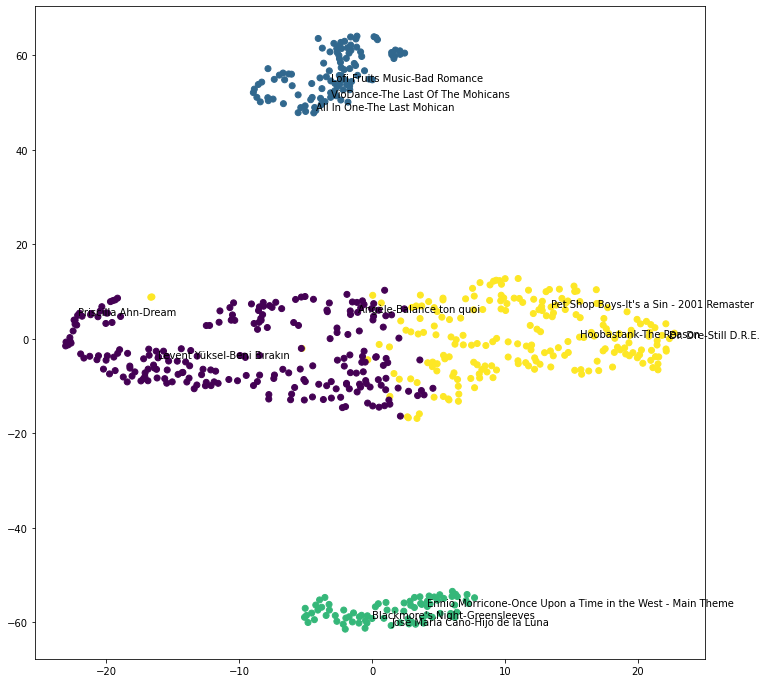

In [ ]:
_, ax = plt.subplots(figsize=(12, 12))
_ = ax.scatter(X_tsne[:,0], X_tsne[:,1], c=df["champions_cluster"].values,)

for track,i in zip(top3inclusters,df.index.unique().get_indexer(top3inclusters)):
    _ = ax.annotate(track, (X_tsne[:,0][i], X_tsne[:,1][i]))      

#### Explainability

In this section, we'll try to understand *how* these songs were assigned to given clusters.

This is important as we'd like to understand if the clustering criteria is similar to our business case, whether we captured something new or whether we made a mistake down the road.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=42)
clf.fit(X_scl_weighted,df["champions_cluster"].values)

RandomForestClassifier(random_state=42)

 98%|===================| 2444/2488 [00:48<00:00]        

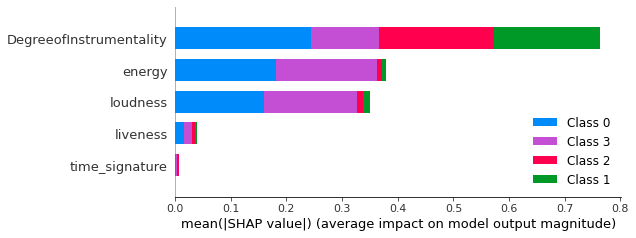

In [ ]:
import shap
explainer= shap.TreeExplainer(clf, data=X_scl_weighted, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_scl_weighted,check_additivity=False)
shap.summary_plot(shap_values, X_scl_weighted, X.columns[cols_used])

Most relevant features are were the following for most clusters:

* DegreeofInstrumentality
* energy
* loudness

*energy* and *loudness* seems to have had a smaller impact on class 1 and class 2 assignation decisions. 

This is in line with our business case as reflected by both *Volkan's preferences* which is directly relevant to the data, the feedback from the team members and the analyses to listener behaviour online.

Obviously more features such as *genre, language, country of origin* and *popularity of artist* may have resulted in more granular clusters.

However, we employed a case-specific test here to manually check if our work made sense - what we call *Volkan's Test* where he listened to random songs from each playlist - and he was pleased with the result. 

**NEXT:** Let's try to figure out why a single song appeared in that specific cluster.

In [ ]:
#Checking the 'i'th record
i=1
print(df.index[i],df.iloc[i,-1])

Camila Cabello-Bam Bam (feat. Ed Sheeran) 3


Now that we know which cluster the song is in, let's check out its SHAP values.

In [ ]:
explainer_raw = shap.TreeExplainer(clf)
shap_values = explainer_raw(X_scl_weighted)

In [ ]:
# force plot of first row for class 1
class_idx = df.iloc[i,-1]
row_idx = i
expected_value = explainer_raw.expected_value[class_idx]
shap_value = shap_values[:, :, class_idx].values[row_idx]

shap.initjs() #veya matplotlib=True
shap.force_plot(
    base_value=expected_value,
    shap_values=shap_value,
    features=X_scl_weighted[row_idx, :],
    feature_names=X.columns[cols_used],
    link="logit",    
)

We predict 0.73 for this song, whereas the base_value is 0.5385. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue(wehre we don't have any). The biggest impact comes from Loudness with a value 0.56. 

## Predicting the cluster/class of new tracks

Now that we have our clusters, we'll move on to the *value-creating* section of our work.

When a user *likes* a new song, we want the new song to be automatically added to it's relevant cluster.

In order to achieve this goal, we'll retrieve data for a new song from the *Spotify API* and preprocess it. Then, we'll cluster it with the existing song data.

Let's begin by going through each step of preparation first.

In [ ]:
#NEIMY's Jubel song, which is a joyful and kind of energic track
newtrack_attributes=sp.audio_features(["4GSDkZt7GcmzBWmsMcpaVO"])[0]
newtrack_attributes

{'danceability': 0.659,
 'energy': 0.615,
 'key': 11,
 'loudness': -5.865,
 'mode': 0,
 'speechiness': 0.0644,
 'acousticness': 0.27,
 'instrumentalness': 0,
 'liveness': 0.187,
 'valence': 0.193,
 'tempo': 119.843,
 'type': 'audio_features',
 'id': '4GSDkZt7GcmzBWmsMcpaVO',
 'uri': 'spotify:track:4GSDkZt7GcmzBWmsMcpaVO',
 'track_href': 'https://api.spotify.com/v1/tracks/4GSDkZt7GcmzBWmsMcpaVO',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4GSDkZt7GcmzBWmsMcpaVO',
 'duration_ms': 164010,
 'time_signature': 4}

In [ ]:
filtered_attr=[(k,v) for k,v in newtrack_attributes.items() if k in list(X.columns)+["instrumentalness"]]
filtered_attr

[('danceability', 0.659),
 ('energy', 0.615),
 ('key', 11),
 ('loudness', -5.865),
 ('acousticness', 0.27),
 ('instrumentalness', 0),
 ('liveness', 0.187),
 ('valence', 0.193),
 ('tempo', 119.843),
 ('time_signature', 4)]

In [ ]:
def instDegree(v):
    if v>0.7:
        return 2
    elif v>0.01:
        return 1
    else:
        return 0
    

final_attr=[x[1] for x in filtered_attr if x[0]!='instrumentalness']
final_attr

[0.659, 0.615, 11, -5.865, 0.27, 0.187, 0.193, 119.843, 4]

In [ ]:
#let's add the degreeofinstrumentalness to the end
final_attr.extend([instDegree(filtered_attr[5][1])])
final_attr

[0.659, 0.615, 11, -5.865, 0.27, 0.187, 0.193, 119.843, 4, 0]

In [ ]:
#scaling
scaleddata=ms.transform(np.array(final_attr).reshape(1,-1))
scaleddata

X does not have valid feature names, but MinMaxScaler was fitted with feature names


array([[ 0.70840276,  0.61771233,  1.        , -2.26119575,  0.27107446,
        -0.30001214,  0.17087859,  0.49201058,  0.75      ,  0.        ]])

In [ ]:
#adding the weights
scaleddata_weighted=scaleddata*wm
scaleddata_weighted

array([[ 0.70840276,  0.61771233,  1.        , -3.39179363,  0.27107446,
        -0.30001214,  0.17087859,  0.49201058,  0.75      ,  0.        ]])

In [ ]:
#for the sake of simplicity - predicting with only champion model
clu.predict(scaleddata_weighted[:,cols_used])

array([3])

This track is indeed in cluster 3. So we seem to have made a good prediction.

We don't want to go through each step one by one for each new song, so we've created the following function:

In [ ]:
def make_prediction(track_id):
    newtrack_attributes=sp.audio_features([track_id])[0]
    filtered_attr=[(k,v) for k,v in newtrack_attributes.items() if k in list(X.columns)+["instrumentalness"]]
    final_attr=[x[1] for x in filtered_attr if x[0]!='instrumentalness']
    final_attr.extend([instDegree(filtered_attr[5][1])])
    scaleddata=ms.transform(np.array(final_attr).reshape(1,-1))
    scaleddata_weighted=scaleddata*wm
    return clu.predict(scaleddata_weighted[:,cols_used])

make_prediction("4GSDkZt7GcmzBWmsMcpaVO")

X does not have valid feature names, but MinMaxScaler was fitted with feature names


array([3])

# Creating the final Playlists

In order to be able to evaluate better, Volkan will give time himself by experiencing the playlists. 

To do this, he will create 2 separate playlists for both *voted_labels* and *champion's_labels*.

In [ ]:
playlistdf=df.join(songs,lsuffix="left",rsuffix="right")[["id","voted_cluster","champions_cluster"]]
playlistdf.head()

id  voted_cluster  \
Artist-Song                                                             
2CELLOS-Despacito               6OIFsi2ov9nSjRrnJWVZIM              1   
2CELLOS-Game of Thrones Medley  4jeh9ZloYVCqvQw17Dg1Mh              1   
2CELLOS-Imagine                 4OfGCb2LOxde2xNiVOdq8H              1   
2CELLOS-May it Be               6KOBMsYaTl9ehUTF3NcX3c              1   
2CELLOS-Moon River              1y2VTYeE7Glc4UQF9kvuzj              1   

                                champions_cluster  
Artist-Song                                        
2CELLOS-Despacito                               1  
2CELLOS-Game of Thrones Medley                  1  
2CELLOS-Imagine                                 1  
2CELLOS-May it Be                               1  
2CELLOS-Moon River                              1

## For voted_labels

In [ ]:
#Warning: This will throw an error when the full notebook is run for the first time.
#The remainder of the notebook should be run again manually.
#This is here to prevent duplicate lists when cells are run multiple times. 
assert False

AssertionError: 

In [ ]:
#If playlists are created for the first time OR we want them to be overwritten,
#rerun should be True, otherwise False
rerun=False

In [ ]:
if rerun:
    v1=spm.user_playlist_create(usr,"Voted_1_Energic",public=False)
    v2=spm.user_playlist_create(usr,"Voted_2_Slow",public=False)
    v3=spm.user_playlist_create(usr,"Voted_3_Medium",public=False)
    v0=spm.user_playlist_create(usr,"Voted_0_Instrumental",public=False)

In [ ]:
v1["id"]

Spotify permits max 100 tracks to be added at once. So we set our code this way.

In [ ]:
if rerun:
    for i in range(4):
        alltracks = playlistdf[playlistdf.voted_cluster==i]["id"].values
        start=0
        for n in range(1+len(alltracks)//100):
            tracks=alltracks[start:(n+1)*100]     
            str_tracks=["spotify:track:" + track for track in tracks]
            playlist=globals()["v"+str(i)]
            spm.user_playlist_add_tracks(usr,'spotify:playlist:'+playlist["id"],str_tracks)
            start+=100

## For champions_labels

In [ ]:
if rerun:
    c1=spm.user_playlist_create(usr,"Champion_1_Slow",public=False)
    c2=spm.user_playlist_create(usr,"Champion_2_Instrumental",public=False)
    c3=spm.user_playlist_create(usr,"Champion_3_Energic",public=False)
    c0=spm.user_playlist_create(usr,"Champion_0_Mixed",public=False)

In [ ]:
if rerun:
    for i in range(4):
        alltracks = playlistdf[playlistdf.champions_cluster==i]["id"].values
        start=0
        for n in range(1+len(alltracks)//100):
            tracks=alltracks[start:(n+1)*100]     
            str_tracks=["spotify:track:" + track for track in tracks]
            playlist=globals()["c"+str(i)]
            spm.user_playlist_add_tracks(usr,'spotify:playlist:'+playlist["id"],str_tracks)
            start+=100

# Final words

**Evaluation of our work**

The idea that created this project came to be when one day Volkan got frustrated about both liking a song and not being able to find it later.

Volkan thought "what if we could auto-group these songs into playlists" - as the most valuable feature of Spotify is to be able to freely create playlists that are also easily accessible.

In this project, we attempted to use the data available in Spotify's public APIs to cluster Volkan's liked songs into meaningful playlists.

We employed a number statistical tests and measures, but the most critical one was *Volkan's Test of Enjoyability*.

At first we were dismayed by the scores we obtained; the low number of clusters we could create and the rather unique list of songs that appeared in each cluster was a negative sign.

Our expectation was to have around 8-12 clusters which would be in line with Volkan's custom playlists.

But, when we ran *Volkan's Test of Enjoyability* where Volkan actually listened to the playlist, the resulting sentiment was much better than expected!

Although there are improvement points, we actually built a feature that did not exist and it did serve its purpose - liked songs were clustered with similar songs into playlists.

**Improvement Points**

We immediately discovered some improvement points as we worked through our exploratory data analysis:

1. **Data Quality:** We were sad to discover that values did not exactly match the description of the features. Our work with *instrumentalness* helped with this issue but handling all cases may prove impossible.

2. **Missing Features:** We believe that some features may be missing. Obviously, as humans, we can easily separate different types of songs and we would expect data to reflect that.\
\
However, we don't know what other information would be pertinent as we are not domain experts. It is obvious because some tracks that cannot be normally considered similar are in the same cluster.\
\
If Spotify's music experts add these features in the future, a better clustering could be done.\
\
(NOTE: *origin*/*country* info is actually available but Volkan doesn't want to include this feature, as he likes to listen the songs regardless of their origin, but rather by their acoustic features.)

3. **Small Dataset:** For our work, we only used Volkan's liked songs. If we could use a larger dataset, potentially from a user with a larger liked song base, we might have gotten better results overall.

**Future Work**

A large advantage of using Spotify is how *playlists* work - it is very easy to create and share them and add new songs to them via its recommender.

Our work can be implemented in several ways to boost this capability:

1. **Recommendation:** Users can be *recommended* to add a liked song to a predefined playlist with a basic prompt, effectively reducing the time for the user to do it manually.

2. **Dynamic Playlists:** When a user likes a song, it can be automatically added to a dynamic playlist generated for each cluster. These would work much similar to *Daily Mixes* already used by Spotify.

This idea was created by **Volkan Yurtseven** to tackle a pain point and we attempted to address it with this project.

We hope to keep working on this notebook and the idea to the point that it becomes a viable feature.

We would very much appreciate any feedback and guidance you may provide.